# w261 Final Project - Clickthrough Rate Prediction


Team 21  

Debalina Maiti, Tiffany (TK) Truong, Dili Wang

Summer 2019, section 6

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

### Context

In the current landscape of digital advertising, both advertisers, the entities paying for the ads, and publishers, the entities actually displaying the ad, need to accurately predict the efficacy of ads based on different variables and contexts. One of the metrics that determine the effectiveness of ads is click-through rate (CTR), which refers to how many users clicked on the ad after it was shown to them. CTR is also important in terms of defining the cost of the ad such that publishers may charge advertisers by cost per click. Publishers set up auctions in which advertisers can bid for an expected cost per impression, which is based on the probability for a click through or conversion through the ad. 

There are many challenges when it comes to predicting these probabilities. First, publishers continuously receive large amounts of web traffic, generating large volumes of data. Due to the nature of the advertising market, models need to be updated through training with new data to maintain performance. Additionally, these data are very high dimensional, but also tend to be very sparse. This data may come from different sources: publishers, advertisers, users, and time. The features may include:

    - context features: website ID, domain ID, device type, etc.
    - content features: the text inside the ad, size of the ad, media type, etc.
    - user features: user ID, registered user, etc. 
    - feedback features: click/no click

Given these challenges, models that predict CTR must be performative at scale in production. They must be able to handle high dimensionality as well as large amounts of data with the ability to retrain and update the model easily. 

### Objectives

In this project, we aimed to build a model that predicts the probability that a user will click on an ad based on data from Criteo, a publisher. Our model was evaluated in terms of logaritmic loss. The data provided include a label (0 or 1) denoting a click or non-click,  13 integer features, and 26 categorical features, which the latter being hashed for anonymity of the users and advertisers. To further maintain privacy and anonymity, Criteo had also withheld feature identification, which posed some challenges in our modeling. This made it difficult to see whether certain values are outliers or what feature transformations would or would not make sense. However, this also forced us to closely examine the data and placed less emphasis on any assumptions we might have had about what goes into predicting the probability that a user will click on the ad.

# __Section 2__ - Algorithm Explanation

### Toy Sample Preparation

In order to test our algorithm and assess feasibility, we built a toy data set by sampling the Criteo data set.  The sample, of size 100, was created one local machine and outputed to a text file, so all member of the team could have access.  The following cells show the code for initializing our notebook, reading in both the raw test and raw training sets creating the toy sample.

In [2]:
#initialization code
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import pyspark
from pyspark.ml.feature import Imputer
import math
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from numpy import allclose
from pyspark.sql import Row
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
sqlContext = SQLContext(sc)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# store path to notebook
PWD = !pwd
PWD = PWD[0]

# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Spark configuration Information (RUN THIS CELL AS IS)
sc.getConf().getAll()

raw_test = PWD + '/data/test.txt'
raw_train = PWD + '/data/train.txt'
rawTestRDD = sc.textFile(raw_test)
rawTrainRDD = sc.textFile(raw_train)

In [8]:
rawTestRDD.count()

6042135

In [9]:
rawTrainRDD.count()

45840617

In [3]:
rtrainRDD, rdevRDD, rtestRDD = rawTrainRDD.randomSplit([0.8,0.1, 0.1], seed = 2018)

In [ ]:
#DO NOT RUN THIS CELL AGAIN, TAKES VERY LONG TIME LOCALLY
#Writing Toy sample to file for easy access
rtoy = rtrainRDD.takeSample(False, 100)

with open("toy.txt", "w") as file:
    file.write(str(rtoy))

In [4]:
def parse_raw_row(row):
    '''
    for each row in the raw data,  output is a list of label and all the features:
        - [label, feature_1, feature_1, ...]
    For first 13 features, change the data type to number.
    Remaining features will of type string.
    For null values, populate None
    '''
    row_values = row.split('\t')
    for i, value in enumerate(row_values):
        if i <14:
            row_values[i] = float(value) if value != '' else None
        else:
            row_values[i] = value if value != '' else None
    # "''"
    return row_values

Based on some averaging calculations performed in GCP early on, we determined that the raw training set read from the original file contained 25% CTR.  In order to make sure that our algorithm performs correctly, we wanted to ensure that our toy sample contains the same clickrate distribution, before proceeding.

In [5]:
#Retrieving toy sample by reading
rtoyRDD = ast.literal_eval(open("toy.txt", "r").read())

toyRDD = sc.parallelize(rtoyRDD).map(parse_raw_row).cache()

#checking that toy sample contains click rates that match training data
toyRDD.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x+y).collect()

[(0.0, 75), (1.0, 25)]

### Gradient Descent Formulation

The focal point of our home-grown machine learning algorithm is to predict cick rates using a logistic regression model.  In order to achieve model optimization, we opted for training through a distributed Gradient Descent algorithm in spark. Ulimately, the CTR probability and result for each data point will be determined via the sigmoid function with the following form - 
$$\sigma(z)=\dfrac{1}{1+e^{-z}}$$
In test data predictions, the the argument is expressed as $z=(\boldsymbol{w}^{T}\boldsymbol{x}_{i}+b)$, where $\boldsymbol{w}$ is the final model vector, $b$ is the final model bias and $\boldsymbol{x}_{i}$ represents the features vector for each data point. The sigmoid function calculation for each data point results in a probability between 0 and 1, where $\sigma(z)\leq0.5$ results in a prediction for a negative (no click, or label = 0) prediction, while $\sigma(z)\geq0.5$ results in a positive (click, or label = 1) prediction

For simplicy, we augmented model vector and features vectors in the following way, so that the bias can be tracked as part of the model vector. 
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$
Therefore, for the entirety of the algorithm, the argument used in all expoential terms has the format $z=(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})$


Our Gradient Descent algorithm relies on the following objective function which measures logarithmic loss:
$$\ell(\boldsymbol{\theta},\boldsymbol{x'},y)=\sum_{i}^{N}-log(\sigma(y_{i}\cdot(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})))=\sum_{i}^{N}-log(\dfrac{1}{1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}})=\sum_{i}^{N}log(1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}})$$
where $y$ represents the outcome, or in this case, the label for each data point.


Deriving the objective function with respect to model vector $\boldsymbol{\theta}$ results in the following format for the gradient:
$$\nabla\boldsymbol{\theta}=\nabla_{\theta}\left\{ \sum_{i}^{N}log(1+e^{y_{i}\cdot(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})})\right\}$$
$$=\sum_{i}^{N}-\boldsymbol{y_{i}}\cdot(\dfrac{e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}}{1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}})\cdot\boldsymbol{x'}_{i}$$
$$=\sum_{i}^{N}-\boldsymbol{y_{i}}\cdot(1-\dfrac{1}{1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}})\cdot\boldsymbol{x'}_{i}$$
$$=\sum_{i}^{N}-\boldsymbol{y_{i}}\cdot(1-\sigma(y_{i}\cdot(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})))\cdot\boldsymbol{x'}_{i}$$
In the notation for the gradient, the final line shown was a particularly useful format in writing our code, as it allowed us to access a version of the sigmoid function which avoided overflow errors.  Additionally, we had intended to add L1 (Lasso) regularization to assist in features selection and L2 (Ridge) regularization enhance model generalization to new data.  The following gradients function for each regularization type were also built into our agorithm, where their calculations were only called if regularization was specified:

**Ridge**: $$\nabla\boldsymbol{\theta_{L2}}=\sum_{i}^{N}-\boldsymbol{y_{i}}\cdot(1-\dfrac{1}{1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}})\cdot\boldsymbol{x'}_{i}+2\lambda\boldsymbol{r}$$
**Lasso** $$\nabla\boldsymbol{\theta_{L1}}=\sum_{i}^{N}-\boldsymbol{y_{i}}\cdot(1-\dfrac{1}{1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}})\cdot\boldsymbol{x'}_{i}+\lambda(\boldsymbol{1}_{>0}(\boldsymbol{r})*2+1)$$
In the equations for regularization above, $\lambda$ is the regularization parameter, a factor that determines how much the regularization term affects the gradient calculation. We also use a special notation for the augmented vector $\boldsymbol{r}$ in the regularization terms, which has the following format:
$$
\boldsymbol{r} :=
\begin{bmatrix}
\mathbf{w}\\
0
\end{bmatrix}
$$
This notation is used to specify that the regularization terms do not affect the bias portion of the augmented weight vector. 



It is important to note here that both the objective function and gradient function actually requires that the training data have outcome values  $y\in\{-1,1\}$.  We discovered early on that because our data is labeled with $y\in\{0,1\}$ instead than $y\in\{-1,1\}$, it is incompatible with the gradient function. While we achieve convergence in our algorithm, the training error is 70% on the toy data.  Therefore, we transformed our training data in the following way:
 1. data points labeled as 1, for positive click, remained as 1
 1. data points labeled as 0, for no click, were changed to -1 for compatibility with gradient function.
In prior attempts, we also tried a different version of the gradient function that was compatible with outcome labels $y\in\{0,1\}$. However, the loss function for this version was far more complicated, resulting in our apprehension with performance.  Ultimately, we opted out of a different version and instead chose to transform our training data with 0 --> -1 labeling. 



Our gradient descent algorithm proceeds in the following steps:
 1. We start with a initial augmented model vector that has an initial bias of 0.25, which is the average CTR of the training set.  The rest of the model vector has 0s, with elements that correspond to each of the features in the features vectors.
 2. Next we apply parallelized gradient descent calculations to the entire data set.  Since the algorithm acts on a Spark RDD, the calculation is performed through a 2-step MapReduce job, where the calculation $-\boldsymbol{y_{i}}\cdot(1-\dfrac{1}{1+e^{-\boldsymbol{y_{i}(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})}}})\cdot\boldsymbol{x'}_{i}$ is done in the map step, and the summation of this calculation over all data points is performed in the reduce step.  A separate 2-step map reduce job is used to calculate the logarithmic loss on the training set simultaneously.
 3. The 2 MapReduce jobs are then iterated for as many steps as needed in order for the logarithmic loss of the training set to reach convergence.  The iterative step performs the following calculation calculation -
 $$\theta=\theta-\eta\cdot\nabla\theta$$
 which specifies how the model vector changes according to the gradient and the learning rate $\eta$.  The resulting model vector from each iteration is then used for gradient descent calculation in the following iteration, until convergence is reached.
 4. We also ran the algorithm multiple times to achieve a smooth gradient descent.  In order to make sure that we are indeed reaching the global minimum of the loss function and we do not overshoot that minimum, we must choose a learning rate $\eta$ that is sufficiently small. In order for the algorithm to be scalable, we also need $\eta$ sufficient large, so that the number of interation steps is not too great in order to reach convergence. 

Once convergence is reached, we assume that we have the optimized model vector. We use another MapReduce job to caculate predictions across a test sample
using $\sigma(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})$ for each features vector $\boldsymbol{x'}_{i}$ and the final model vector determined from gradient descent convergence, $\boldsymbol{\theta}$.  We also calculate the following metrics to measure model performance from each version to the next:
$$Accuracy=\dfrac{TN+TP}{Rows}$$
$$Precision=\dfrac{TP}{TP+FP}$$
$$Recall=\dfrac{TP}{TP+FN}$$
$$F1-Score=\dfrac{2\cdot(Recall*Precision)}{Recall+Precision}$$
where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.  The actual implementation of these metrics are not done until section 4 where we have test and train samples. 



The algorithm did face a few challenges during the testing and implementation.  Therefore, we made the following modifications to overcome these challenges
 1. The first challenge we faced is overflow errors due to $e^{-arg}$ calculations being too large for float storage, for some negaive values of the arg.  We therefore leveraged the symmetry of the sigmoid function expressed by the following equation to overcome this problem -  
$$1-\sigma(-z)=1-\dfrac{1}{1+e^{z}}=\dfrac{1+e^{z}}{1+e^{z}}-\dfrac{1}{1+e^{z}}=\dfrac{e^{z}}{1+e^{z}}=\dfrac{1}{1+e^{-z}}=\sigma(z)$$
 For negative values of the argument, we $1-\sigma(-arg)$ to avoid an overflow error, which we used the standard form of the sigmoid function for positive values of the argument.  The representation of the sigmoid function can be seeing in the set of functions below
 2. The second challenge is that we often faced a math out of range error with the natural log function, given that sometimes our calculation resulted in log(arg), where arg<0.  To circumvent this issue, we instead applied the translation log(1+arg) to the objective function:
$$\ell^{\boldsymbol{'}}(\boldsymbol{\theta},\boldsymbol{x'},y)=\sum_{i}^{N}-log(1+\sigma(y_{i}\cdot(\boldsymbol{\theta}^{T}\boldsymbol{x'}_{i})))$$
 In testing, we found that this does not affect convergence or the resulting optimized model vector from the algorithm and simply results in y-axis translation of the log-loss calculations.
 

#### Functions
The following cell contains major functions used for toy sample processing as well as gradient descent.  These functions were also included in the final implementation of the end to end algorithm.  For toy sample testing, we only used numeric columns to validate that the gradient descent algorithm will succeed. 
- We first extract only numeric columns from the toy sample, and apply imputation to populate null values with the feature average.  This ensures that null values do not cause errors in our algorithm
- Next we apply feature scaling by transforming all feature values to a z-score based on feature mean and standard deviation. The scaling is done to ensure that the loss function surface is symmetic and the gradient descent path will be smooth.  Scaling prevents any one feature with large values from dominating the gradient caculation and resulting in a zig-zag path. 
- We have separate functions for the signmoid, the objective function for calculating log loss and the gradient calulation. The latter two functions call on the signmoid helper. 
- There is also a function used for graphing train and test losses.  We run this function repeatedly in testing to ensure parameters like learning rate $\eta$ and number of steps are reasonable.  
- Lastly, we have a function that calculates all 4 metrics, using the predicter function outcomes as the input. The predictor function peforms probability calculations using the sigmoid and also assigns prediction label depending on if the probability is greater than or less than 0.5.

In [39]:
#ALL ALGORITHM FUNCTIONS

def imputeNumeric(numeric_DF, endCol):
    '''
    takes a spark df with continuous numeric columns
    outputs a spark df where all null values are replaced with the column average
    
    the first column, which is the outcome values, are preserved
    '''
    outputColumns=["{}_imputed".format(c) for c in numeric_DF.columns[1:endCol]]
    catColumns = ["{}".format(c) for c in numeric_DF.columns[endCol:]]
    
    imputer = Imputer(
        inputCols=numeric_DF.columns[1:endCol], 
        outputCols=outputColumns
    )

    model = imputer.fit(numeric_DF)

    imputedDF = model.transform(numeric_DF).select(['_1']+outputColumns+catColumns)

    return imputedDF

def scaleFeatures(imputedDF, endCol):
    '''
    inputs imputed data frame with no null values and continuous features
    transforms the data frame into 2 column data frame with first column as label and second column as dense vector of features
    scales all features using the StandardScalar
    returns 2 column dataframe with scaled features
    '''
    
    transformedImputedDF = imputedDF.rdd.map(lambda x: (x[0], Vectors.dense(x[1:endCol]))).toDF(['label', 'x'])
    
    scaler = StandardScaler(inputCol="x", 
                        outputCol="features",
                        withStd=True, withMean=True)

    scalerModel = scaler.fit(transformedImputedDF)
    scaledDF = scalerModel.transform(transformedImputedDF).select(['label', 'features'])
    
    return scaledDF


def sigmoid(arg):
    """helper function used to prevent math range error
    
    also makes loss and gradient functions easier to read"""
    
    if arg < 0:
        return 1 - 1 / (1 + math.exp(arg))
    else:
        return 1 / (1 + math.exp(-arg))

def LRLoss(augmentedData, W):
    """Takes augmented data and calculates log loss for current model vector W
    
    AUGUMENTATION MUST OCCUR BEFORE INPUT TO FUNCTION
    
    data must be transformed in the following way to use this function:
        y = 1 --> y' = 1
        y = 0 --> y' = -1"""
    
    loss = augmentedData.map(lambda x: -math.log(1+sigmoid(x[0]*np.dot(W, x[1]))))\
                        .sum()
    return loss

def GDUpdate(augmentedData, W, learningRate = 0.05, regType = None, regParam = 0.1):
    
    """Takes augmented data and calculates each gradient step to current model vector W
    
    AUGUMENTATION MUST OCCUR BEFORE INPUT TO FUNCTION
    
    data must be transformed in the following way to use this function:
        y = 1 --> y' = 1
        y = 0 --> y' = -1 
        
    Includes the regularization terms for:
        1. L1 - lasso
        2. L2 - Ridge"""
    
    new_model = None
    
    if regType == 'ridge':
        L2reg = W*1
        L2reg[0] = 0 #first value is the y-intercept (bias) term and should be removed from regularization
        
        grad = augmentedData.map(lambda x: -x[0]*(1-sigmoid(x[0]*np.dot(W, x[1])))*x[1]+2*regParam*L2reg)\
                            .reduce(lambda x,y: x + y)
    
    elif regType == 'lasso':
        L1reg = W*1
        L1reg[0] = 0 #first value is the y-intercept (bias) term and should be removed from regularization
        L1reg = (L1reg>0).astype(int)*2-1
        
        grad = augmentedData.map(lambda x: -x[0]*(1-sigmoid(x[0]*np.dot(W, x[1])))*x[1]+regParam*L1reg)\
                            .reduce(lambda x,y: x + y)
        
    else:
        grad = augmentedData.map(lambda x: -x[0]*(1-sigmoid(x[0]*np.dot(W, x[1])))*x[1])\
                            .reduce(lambda x,y: x + y)
    
    new_model = W-learningRate*grad
    
    return new_model

def GradientDescent(trainRDD, wInit, testRDD = None, nSteps = 20, 
                    learningRate = 0.025, regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        model = GDUpdate(trainRDD, model,learningRate, regType, regParam)
        training_loss = LRLoss(trainRDD, model)
        train_history.append(training_loss)
        if testRDD != None:
            test_loss = LRLoss(testRDD, model)
            test_history.append(test_loss)

        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            if testRDD != None:
                print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

def plotErrorCurves(trainLoss,testLoss = None, title = None):
    """
    Helper function for plotting.
    Args: trainLoss, testLoss
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Train Loss')
    if testLoss != None:
        ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()
    
    
def predictionLabel(x, model, formal = False):
    """
    takes any features vector and model vector
    predicts the label based on the following logic - 
        1. 1 if probability using sigmoid function > 0.5
        2. otherwise -1 (which represents 0)
        
    input vectors must be augmented to have the same dimension as model
    
    if formal = False, can only be applied to RDD where y values have been transformed to {-1, 1}
    
    for formal = True, applied to RDDs where y values are {0, 1}
    """
    
    prob = sigmoid(np.dot(model, x))
    if prob > 0.5:
        return [1, prob]
    else:
        if formal:
            return [0, prob]
        else:
            return [-1, prob]
        
def modelMetrics(augTrain, augTest, model):
    '''prints all relevant prediction metrics from model version
    input data must be augmented already'''
    
    #print outputs and some metrics
    print("\nFinal Model Vector:", model)
    
    # Predict Labels using both models
    GDPredsTrain = augTrain.map(lambda x: (x[0], predictionLabel(x[1], model))).cache()
    GDPredsTest = augTest.map(lambda x: (x[0], predictionLabel(x[1], model))).cache()


    #METRICS
    # Calculate Train Errors for comparison
    GDTrainError = GDPredsTrain.filter(lambda lp: lp[0] != lp[1][0]).count() / float(augTrain.count())

    TN = GDPredsTest.filter(lambda lp: lp[0] == lp[1][0]).filter(lambda lp: lp[0] == -1.0).count()
    TP = GDPredsTest.filter(lambda lp: lp[0] == lp[1][0]).filter(lambda lp: lp[0] == 1.0).count()
    FP = GDPredsTest.filter(lambda lp: lp[0] != lp[1][0]).filter(lambda lp: lp[0] == -1.0).count()
    FN = GDPredsTest.filter(lambda lp: lp[0] != lp[1][0]).filter(lambda lp: lp[0] == 1.0).count()

    Accuracy = float(TN+TP)/float(augTest.count())
    Precision = float(TP)/float(TP+FP)
    Recall = float(TP)/float(TP+FN)
    F1 =  2*(Recall*Precision)/(Recall+Precision)


    #Print Train Errors
    print("\nGradient Descent Training Error:",  str(GDTrainError))

    #Print Metrics on Test Data
    print("\n Prediction Metrics on Test Data")
    print("Accuracy:", Accuracy)
    print("Precision:", Precision)
    print("Recall:", Recall)
    print("F1:", F1)

    #Print Log Loss of Models
    print("\nGradient Descent Final Model Log Loss on Train Data:", LRLoss(augTrain, model))
    #Print Log Loss of Models
    print("\nGradient Descent Final Model Log Loss on Test Data:", LRLoss(augTest, model))

#### Gradient Descent Testing on Toy Sample

For fast testing of the Gradient Descent algorithm, we intially used only the numeric columns of the Toy sample of 100 rows.  In section 4, we test the algorithm again on a 10 K sample that does include categorical features.  In toy sample test, we apply imputation, scaling and augmentation to all numerical features.  We then apply the gradient descent algorithm until our iterations show convergence. 

In [9]:
#Process Toy Sample into Usable format for Algorithm testing:

toyDF = sc.parallelize(rtoyRDD).map(lambda x: x.split('\t')).toDF()

#extract only numeric values and transform from str to int
toyDFNum = sc.parallelize(rtoyRDD)\
            .map(lambda x: x.split('\t'))\
            .map(lambda x: x[:14])\
            .map(lambda x: list(map(lambda y: float(y) if y!='' else None, x)))\
            .toDF()

#impute null values with column average
imputedToyDF = imputeNumeric(toyDFNum, 14)

#normalize
scaledToyDF = scaleFeatures(imputedToyDF, 14)


#Transform scaledToyDF to RDD for Gradient Descent Processing
#Transform y-values in the following way for compatibility with gradient descent function - 
### y = 1 -> y' = 1
### y = 0 -> y' = -1

scaledToyRDD = scaledToyDF.rdd.map(lambda x: (2*x[0]-1, np.array(x[1]))).cache()

#apply augmentation
augScaledToyRdd = scaledToyRDD.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()

augScaledToyRdd.take(1)

[(-1.0,
  array([ 1.00000000e+00,  6.21463808e-17, -3.11172917e-01,  0.00000000e+00,
          0.00000000e+00, -5.92084497e-02, -2.50402747e-01, -1.59311211e-01,
          1.35240269e+00, -2.32427062e-02,  0.00000000e+00, -1.81123980e-02,
          0.00000000e+00,  0.00000000e+00]))]

In [37]:
wInit = np.array([0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
start = time.time()
LogLossToy, test, ToyModels = GradientDescent(augScaledToyRdd, wInit, testRDD = None, nSteps = 150, learningRate = 0.025)
print(f"\n... trained {len(ToyModels)} iterations in {time.time() - start} seconds")


... trained 150 iterations in 51.1390438079834 seconds


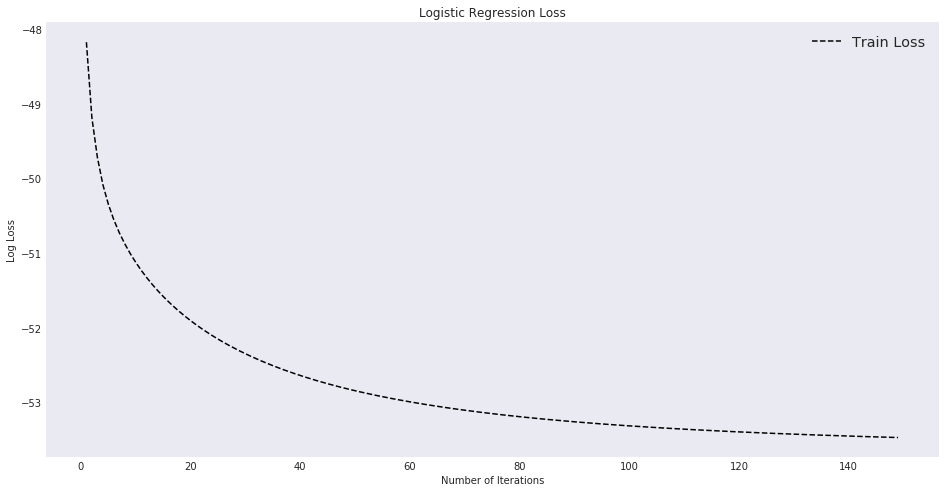

In [38]:
plotErrorCurves(LogLossToy,title = 'Logistic Regression Loss' )

#### Validation of Calculations using MLLib Logistic Regression

To check that our math for the gradient descent algorithm is correct, we perform validation by apply the MLLib LogisticRegression() function to the toy data set.  In the output below, we see that both our home-grown algorithm and the MLLib function results in the same training error of 17%.  In comparison of the resulting model vectors, we see that the majority of the vector values are very similar, but two features (1 and 5) show very different coefficients. Based on these results, we believe that the mathematical formulations in our home-grown algorithm is mostly correct given that predictions result in similar accuracy between the home-grown algorithm and the MLLib Algorithm.  The differences in the model vectors may be due to averaging/ensemble techniques within the MLLib function.  We actually have further evidence of averaging in the validation we performed in section 4 on the 10K sample. 

In [12]:
#test MLLib Logistic Regression

#fit logistic regression with no regularization
lr = LogisticRegression(maxIter=150, regParam=0, elasticNetParam=0)
lrModel = lr.fit(scaledToyDF)

# Create model vectors for comparison
## gradient descent model from last iteration 
GDModelVector = ToyModels[-1]
## full MLLib Model with y-intercept as first term
MLLibModelVector = np.append(np.array(lrModel.intercept),np.array(lrModel.coefficients))

# Predict Labels using both models
GDPreds = augScaledToyRdd.map(lambda x: (x[0], predictionLabel(x[1], GDModelVector)))
MLLibPreds = augScaledToyRdd.map(lambda x: (x[0], predictionLabel(x[1], MLLibModelVector)))


# Calculate Train Errors for comparison
GDTrainErr = GDPreds.filter(lambda lp: lp[0] != lp[1][0]).count() / float(augScaledToyRdd.count())
MLLibTrainErr = MLLibPreds.filter(lambda lp: lp[0] != lp[1][0]).count() / float(augScaledToyRdd.count())

#Print Train Errors
print("Gradient Descent Training Error = " + str(GDTrainErr))
print("MLLib Training Error = " + str(MLLibTrainErr))

#Print Log Loss of Models
print("\nGradient Descent Final Model Log Loss = ", LRLoss(augScaledToyRdd, GDModelVector))
print("MLLib Model Loss = ", LRLoss(augScaledToyRdd, MLLibModelVector))

#Print Models for comparison:
print("\nGradient Descent Final Model= ", GDModelVector)
print("\nMLLib Model = ", MLLibModelVector)

Gradient Descent Training Error = 0.17
MLLib Training Error = 0.17

Gradient Descent Final Model Log Loss =  -53.46986998903426
MLLib Model Loss =  -53.6901097739705

Gradient Descent Final Model=  [-2.09665755 -0.30055992 -0.86789015 -0.50780911 -0.23972162 -1.82944936
  0.16724705 -0.96136189  0.1498718  -0.91040641  0.59562242  1.06465854
 -2.72953051  0.38219304]

MLLib Model =  [-2.57477739 -0.00559714 -0.95921739 -0.50701716 -0.23574585 -4.19608438
  0.2181879  -1.30960337  0.11420849 -0.84883709  0.57246553  1.24033065
 -2.83202951  0.35282215]


# __Section 3__ - EDA & Challenges

Since the provided training dataset is over 45 million rows even prior to performing random splits to preserve portions of the data for development and testing, performing exploratory data analysis (EDA) on the full dataset will be challenging. For most of our EDA, we utilized a random sample of a little less than 11,000 rows from the trainRDD after we split the large training data into trainRDD, devRDD, and testRDD. To obtain this sample, we utilized the following script in GCP to produce a text file to import into the notebook. 

```python
import pyspark

sc = pyspark.SparkContext()
rawTestRDD = sc.textFile('gs://gcp-bucket/data/test.txt')
rawTrainRDD = sc.textFile('gs://gcp-bucket/data/train.txt')

trainRDD, devRDD, testRDD = rawTrainRDD.randomSplit([0.8,0.1, 0.1], seed = 2018)
edaRDD, otherRDD = trainRDD.randomSplit([0.0003, 0.9997], seed = 2018)
print(edaRDD.collect())
```

First, we examined the overall click through rate (CTR) to get a sense of how balanced the training dataset is, especially given that it has over 45 million rows. We found a CTR rate of a little over 25% in the large training dataset through GCP and confirmed that our EDA sample has approximately the same proportion. We used Spark jobs for our analysis and Pandas, Matplotlib, and Seaborn for the visualization components.

In [6]:
# read in the EDA text file with the EDA sample
f = open("eda.txt", "r")
eda = ast.literal_eval(f.read())
f.close()

# modified version of Dili's function
def parse_eda_row(row):
    '''
    for each row in the raw data,  outputs the following tuple:
        - (label, features_vector)
        where features_vector is comma separated string of features
        features with no value are replaced by empty string ''
    '''
    row_values = row.split('\t')
    # added modification here
    new_values = ["'" + value + "'" if value != '' else "''" for value in row_values[1:]]
    output_string = ",".join(new_values)
    return (row_values[0], output_string)

eda_rdd = sc.parallelize(eda)
# parse each row and return in list form for pandas
eda_pd = eda_rdd.map(lambda x: x.split('\t')).collect()
# parsed eda rdd
parsed_eda = eda_rdd.map(parse_eda_row).cache()

# create pandas dataframe for visualizations
features = ['label'] + list(range(1, 40))
eda_df = pd.DataFrame(eda_pd, columns = features)
# replace all the empty strings with NaN values
eda_df = eda_df.replace(r'^\s*$', np.nan, regex=True)

# calculate click through rate
ctr = eda_rdd.map(lambda x: x.split('\t')).filter(lambda x: x[0] == '1').count() / eda_rdd.map(lambda x: x.split('\t')).count()

print("EDA row count:", len(eda_pd))
print("EDA sample CTR: {:.2f}%".format(ctr * 100))

EDA row count: 10758
EDA sample CTR: 25.57%


### Missing Values by Feature
Our analysis showed that there are some columns with a big portion of missing values with some having over 76% of the values missing. Even if we performed some form of imputation, this may lead to bias in our model. Thus, this provided support in excluding the following features in our model: 1, 10, 12, 32, 33, 35, 38, and 39. We also noted that there are 15 features that have no missing values. There are a few features that share the same number of missing values, which suggested that some rows might have more missing values than others.

In [7]:
def feat_emissions(row):
    """
    For each key-value pair, parse the features from string representation 
    and emit numerical feature keys, the value, and 1 count
    """
    label, values = row
    values = ast.literal_eval(values)
    
    for key, val in enumerate(values, start = 1):
        yield (str(key), val, 1)

row_count = parsed_eda.count()
total = sc.broadcast(row_count)

na_counts = parsed_eda.flatMap(feat_emissions) \
                      .filter(lambda x: x[1] == '') \
                      .map(lambda x: (x[0], x[2])) \
                      .reduceByKey(lambda a, b: a + b) \
                      .map(lambda x: (x[0], x[1], x[1]/total.value)) \
                      .sortBy(lambda x: x[2], ascending = False) \
                      .collect()

for feat in na_counts:
    print('Feature {}  | {} NAs  | {:.2f}%'.format(feat[0], feat[1], feat[2]*100))

na_feats = [int(feat[0]) for feat in na_counts]

no_nas = []

for n in range(1, 40):
    if n not in na_feats:
        no_nas.append(n)

print("\nThe following features have no missing values:", no_nas)

Feature 12  | 8215 NAs  | 76.36%
Feature 35  | 8202 NAs  | 76.24%
Feature 1  | 4866 NAs  | 45.23%
Feature 10  | 4866 NAs  | 45.23%
Feature 33  | 4717 NAs  | 43.85%
Feature 32  | 4717 NAs  | 43.85%
Feature 38  | 4717 NAs  | 43.85%
Feature 39  | 4717 NAs  | 43.85%
Feature 6  | 2494 NAs  | 23.18%
Feature 4  | 2325 NAs  | 21.61%
Feature 13  | 2325 NAs  | 21.61%
Feature 3  | 2290 NAs  | 21.29%
Feature 19  | 1284 NAs  | 11.94%
Feature 9  | 499 NAs  | 4.64%
Feature 7  | 499 NAs  | 4.64%
Feature 11  | 499 NAs  | 4.64%
Feature 16  | 364 NAs  | 3.38%
Feature 17  | 364 NAs  | 3.38%
Feature 29  | 364 NAs  | 3.38%
Feature 34  | 364 NAs  | 3.38%
Feature 25  | 364 NAs  | 3.38%
Feature 37  | 364 NAs  | 3.38%
Feature 5  | 282 NAs  | 2.62%
Feature 8  | 4 NAs  | 0.04%

The following features have no missing values: [2, 14, 15, 18, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 36]


### Missing Values by Row

We also examined missing values from the row perspective both generally and specifically for rows with the click (1) and non-click (0) labels. The plot below shows the distribution of missing values for all rows for this EDA sample. There are 186 rows that don't have any missing values at all, which is approximately 2% of this sample. In general, we noted that there are a handful of rows that are missing 20-22 values out of the 39 features. It appears that on average, a row will have about 5 missing values. We looked at the distributions of the click and non-click examples separately in case we found that one class tended to have more missing values than the other. Our analysis discovered that the distribution of missing values per row are similar for rows that are clicks versus non-clicks. 

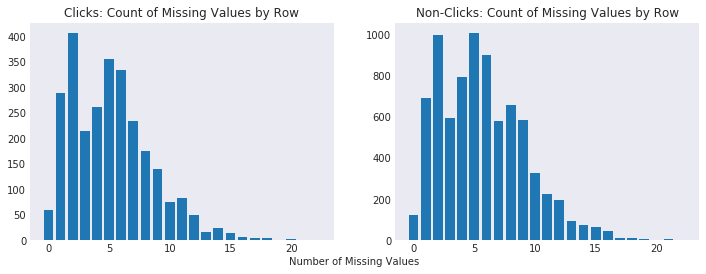

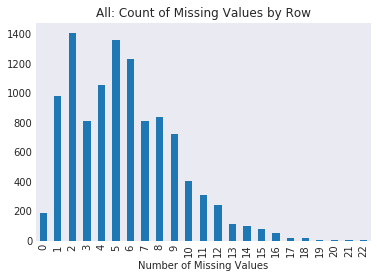

In [8]:
def row_na_count(row, emit_label = False):
    """
    For each row, parses the values and counts the missing values.
    If emit_label = True, then emits a key-value pair that has the label (0 or 1)
    If emit_label = False, then emits a key-value pair that has only the count
    """
    
    label, values = row
    values = ast.literal_eval(values)
    
    count = 0
    for val in values:
        if val == '':
            count += 1
    
    if emit_label:
        return ((label, count), 1)
    else:
        return (count, 1)

# get the missing values for all rows
row_na_counts = parsed_eda.map(row_na_count) \
                          .reduceByKey(lambda a, b: a + b) \
                          .collect()

# get missing values for rows that resulted in clicks
click_row_na = parsed_eda.map(lambda x: row_na_count(x, emit_label = True)) \
                        .filter(lambda x: x[0][0] == '1') \
                        .reduceByKey(lambda a, b: a + b) \
                        .map(lambda x: (x[0][1], x[1])) \
                        .collect()

# get missing values for rows that resulted in non-clicks
noclick_row_na = parsed_eda.map(lambda x: row_na_count(x, emit_label = True)) \
                        .filter(lambda x: x[0][0] == '0') \
                        .reduceByKey(lambda a, b: a + b) \
                        .map(lambda x: (x[0][1], x[1])) \
                        .collect()

# create pandas dataframes for plotting
row_df = pd.DataFrame(row_na_counts).sort_values(by = [0])
row_df.set_index(0, inplace = True)
click_df = pd.DataFrame(click_row_na).sort_values(by = [0])
click_df.set_index(0, inplace = True)
noclick_df = pd.DataFrame(noclick_row_na).sort_values(by = [0])
noclick_df.set_index(0, inplace = True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

row_df.plot(kind = 'bar', legend = None)
plt.title("All: Count of Missing Values by Row")
plt.xlabel("Number of Missing Values")

ax1.bar(click_df.index.values, click_df[1])
ax1.title.set_text("Clicks: Count of Missing Values by Row")

ax2.bar(noclick_df.index.values, noclick_df[1])
ax2.title.set_text("Non-Clicks: Count of Missing Values by Row")

fig.text(0.5, 0.04, "Number of Missing Values", ha='center')
plt.show()

### Examining the Integer Features

The following plots show that there is heavy positive skew for all of the integer features. For most of the integer features, the most frequent values are very small with the bins closest to zero being the biggest. The histograms also showed us that the features are on vastly different scales. For example, Feature 1 ranges from 0 to 200 while Feature 3 ranges from 0 to 40000. This suggested that these features need to undergo scaling as a part of preprocessing prior to modeling. 

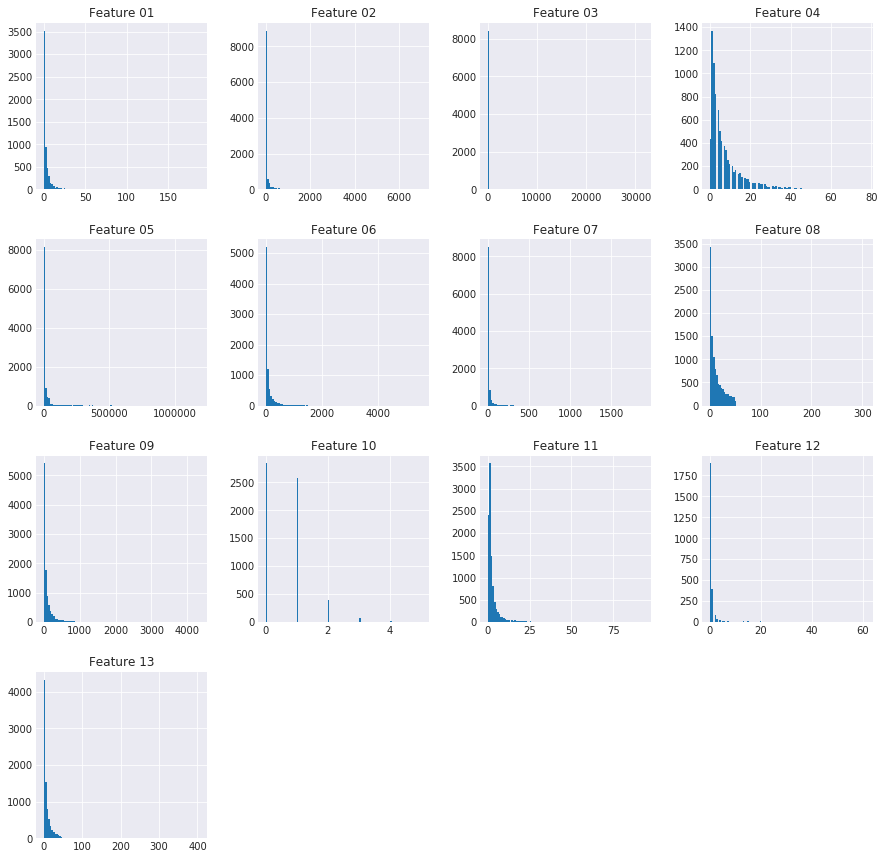

In [11]:
int_cols = ['Feature 0' + str(n) if n < 10 else 'Feature ' + str(n) for n in range(1, 14)]
pd.DataFrame(np.float64(eda_df[features[1:14]]), columns = int_cols).hist(figsize = (15, 15), bins = 100)
plt.show()

We also performed correlation analysis between different pairings of the integer features as shown below. There are strong positive correlations for the following pairs: Features 4 and 13, Features 7 and 11, Features 8 and 13, Features 4 and 8. There is a moderate negative correlation for Features 5 and 10 and Features 6 and 10. This is important to consider as we build the model so we can avoid collinearity.

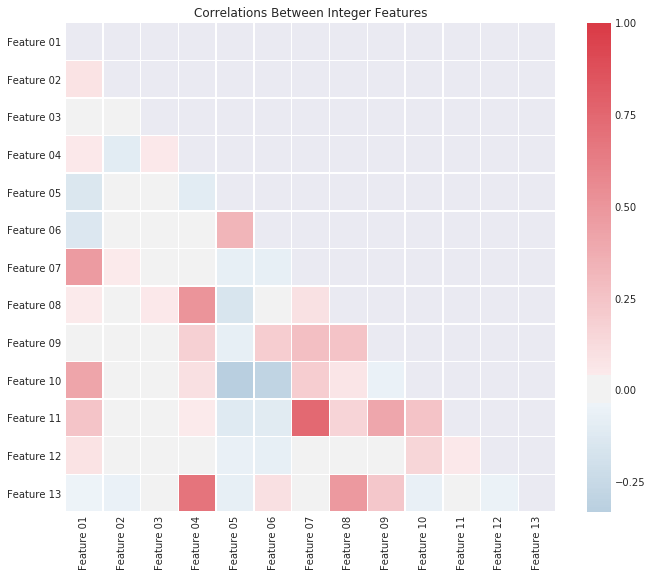

In [12]:
corr = pd.DataFrame(np.float64(eda_df[features[1:14]]), columns = int_cols).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations Between Integer Features")
plt.show()

### Examining the Categorical Features

With 39 features total and 26 of them being categorical, our dataset has the potential to increase in dimensionality. It is not feasible to one-hot encode by every category within the categorical features. Thus, we need to get a sense of how many unique categories are in each feature in order to determine approaches to binning and one-hot encoding. Based on the sample we took for EDA, Features 16, 17, 20, 23, 25, 29, 34, and 39 contain the most unique categories with over 30% of the categories being unique. feature 16 has the most unique categories at over 60%. Besides Feature 39, the other features do not have many missing values. 

In [9]:
def cat_feat_emissions(row, filter_feats = None):
    """
    For each key-value pair, parse the categorical features from string representation 
    and emit composite key for feature number and value and 1 count
    """
    label, values = row
    values = ast.literal_eval(values)
    
    emissions = []
    
    for key, val in enumerate(values[13:], start = 14):
        if filter_feats != None:
            if val != '' and str(key) in filter_feats:
                emissions.append((str(key) + "-" + val, 1))
        else:
            if val != '':
                emissions.append((str(key) + "-" + val, 1))
    
    return emissions

# parse the categorical features and create composite keys with the feature number and categorical value
# to detect unique categories within each feature
uniq_rdd = parsed_eda.flatMap(cat_feat_emissions) \
                    .reduceByKey(lambda a, b: a + b) \
                    .map(lambda x: (x[0].split("-")[0], 1)) \
                    .reduceByKey(lambda a, b: a + b) \
                    .cache()

# join with calculation of how many non-missing values are in the feature to get a sense of uniqueness
nonna_rdd = parsed_eda.flatMap(feat_emissions) \
                      .filter(lambda x: x[1] != '') \
                      .map(lambda x: (x[0], x[2])) \
                      .reduceByKey(lambda a, b: a + b) \
                      .join(uniq_rdd) \
                      .map(lambda x: (x[0], (x[1][0], x[1][1], x[1][1]/x[1][0]))) \
                      .cache()

cat_uniq = nonna_rdd.sortBy(lambda x: x[1][2], ascending = False).collect()

for feat in cat_uniq:
    print("Feature {} | Unique Count: {:.0f} | Total Non-NaN: {} | {:.2f}% unique".format(feat[0], feat[1][1], feat[1][0], feat[1][2] * 100))

Feature 16 | Unique Count: 6325 | Total Non-NaN: 10394 | 60.85% unique
Feature 25 | Unique Count: 5939 | Total Non-NaN: 10394 | 57.14% unique
Feature 34 | Unique Count: 5689 | Total Non-NaN: 10394 | 54.73% unique
Feature 29 | Unique Count: 5355 | Total Non-NaN: 10394 | 51.52% unique
Feature 17 | Unique Count: 4525 | Total Non-NaN: 10394 | 43.53% unique
Feature 39 | Unique Count: 2110 | Total Non-NaN: 6041 | 34.93% unique
Feature 20 | Unique Count: 3514 | Total Non-NaN: 10758 | 32.66% unique
Feature 23 | Unique Count: 3469 | Total Non-NaN: 10758 | 32.25% unique
Feature 37 | Unique Count: 2810 | Total Non-NaN: 10394 | 27.03% unique
Feature 24 | Unique Count: 2216 | Total Non-NaN: 10758 | 20.60% unique
Feature 28 | Unique Count: 2179 | Total Non-NaN: 10758 | 20.25% unique
Feature 26 | Unique Count: 1830 | Total Non-NaN: 10758 | 17.01% unique
Feature 31 | Unique Count: 1245 | Total Non-NaN: 10758 | 11.57% unique
Feature 32 | Unique Count: 559 | Total Non-NaN: 6041 | 9.25% unique
Feature 15

We examined the frequency counts of respective categories in these "highly unique" features and found that a big percentage of the unique categories only appear once. For example, Feature 16 has the most unique categories, but almost 90% of these have a frequency count of 1. Perhaps this means that Feature 16 is some kind of unique identifier such as user ID. Given that these features contain so many unique categories, we argue that these features will likely have low predictive value and will exclude them in our feature selection. 

In [10]:
# get the count of categories that only appear once in the "highly unique features" (> 30% unique)

low_freq = parsed_eda.flatMap(cat_feat_emissions) \
        .reduceByKey(lambda a, b: a + b) \
        .filter(lambda x: x[1] == 1) \
        .map(lambda x: (x[0].split("-")[0], 1)) \
        .reduceByKey(lambda a, b: a + b) \
        .join(nonna_rdd) \
        .map(lambda x: (x[0], (x[1][0], x[1][1][2], x[1][1][1], x[1][0]/x[1][1][1]))) \
        .sortBy(lambda x: x[1][1], ascending = False) \
        .take(8)

for feat in low_freq:
    print("Feature {} | One-offs: {} | Total Unique: {:.0f} | {:.2f}%".format(feat[0], feat[1][0], feat[1][2], feat[1][3] * 100))

Feature 16 | One-offs: 5644 | Total Unique: 6325 | 89.23%
Feature 25 | One-offs: 5235 | Total Unique: 5939 | 88.15%
Feature 34 | One-offs: 4960 | Total Unique: 5689 | 87.19%
Feature 29 | One-offs: 4577 | Total Unique: 5355 | 85.47%
Feature 17 | One-offs: 3657 | Total Unique: 4525 | 80.82%
Feature 39 | One-offs: 1485 | Total Unique: 2110 | 70.38%
Feature 20 | One-offs: 1860 | Total Unique: 3514 | 52.93%
Feature 23 | One-offs: 2234 | Total Unique: 3469 | 64.40%


We utilized Breiman's algorithm in our strategy of binning the remaining categorical features. Since there are more non-clicks than clicks in the data, many of the categories have ranks closer to zero after we applied the algorithm. 

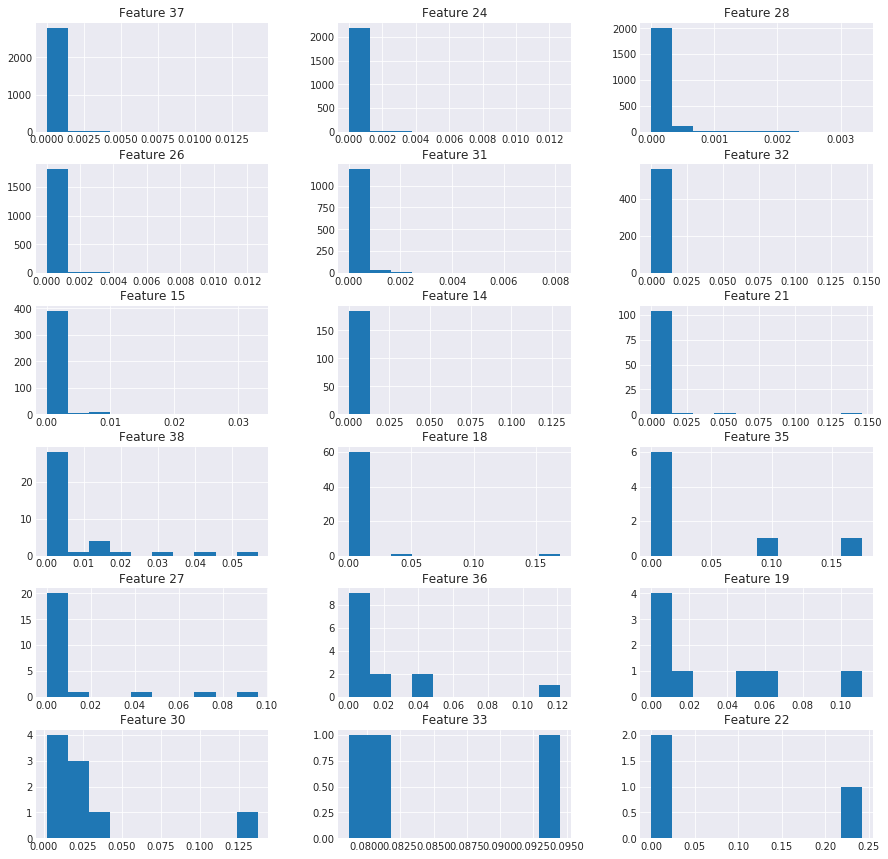

In [40]:
def cat_feats_label(row, filter_feats):
    """
    For each key-value pair, parse the categorical features from string representation 
    and emit composite key for feature number and value and 1 count
    """
    label, values = row
    values = ast.literal_eval(values)
    
    emissions = []
    
    for key, val in enumerate(values[13:], start = 14):
        if val != '' and str(key) in filter_feats:
            if label == '1':
                emissions.append((str(key) + "-" + val, 1))
            elif label == '0':
                emissions.append((str(key) + "-" + val, 0))
    
    return emissions

def format_result(pair):
    """ 
    Takes the pair and splits the composite key into separate values
    and calculates total outcome to frequency ratio
    """
    key, vals = pair
    feat, cat = vals[0][0].split("-")
    
    return (key, cat, vals[0][1]/vals[1])

# since we're excluding the highly unique categories, we'll get the remaining features 
# and broadcast as a way to filter
remaining_feats = [feat[0] for feat in cat_uniq[8:]]
filter_feats = sc.broadcast(remaining_feats)

# get category frequencies for just the remaining features
freq_rdd = parsed_eda.flatMap(feat_emissions) \
                     .filter(lambda x: x[0] in filter_feats.value) \
                      .filter(lambda x: x[1] != '') \
                      .map(lambda x: (x[0], x[2])) \
                       .reduceByKey(lambda a, b: a + b) \

# get the outcome counts for these categories and join with frequency rdd
# format the result for pandas
binning = parsed_eda.flatMap(lambda x: cat_feats_label(x, filter_feats.value)) \
                    .reduceByKey(lambda a, b: a + b) \
                    .map(lambda x: (x[0].split("-")[0], (x[0], x[1]))) \
                    .join(freq_rdd) \
                    .map(format_result) \
                    .collect()

# create pandas dataframe for visualization
binning_df = pd.DataFrame(binning)

fig, axes = plt.subplots(6, 3, figsize=(15, 15))

# indices for the subplots
n = 0
m = 0

# loop through the results to plot distribution of the ratios for binning categorical variables
for feat in remaining_feats:
    binning_df[binning_df[0] == feat].hist(bins = 10, ax = axes[m, n])
    title = "Feature " + feat
    axes[m, n].title.set_text(title)
    # update and reset the indices accordingly
    if n < 2:
        n += 1
    elif n == 2:
        n = 0
        m += 1

#fig.savefig('binning_eda_updated.png')
plt.show()

# __Section 4__ - Algorithm Implementation

### Features Selection Process

Prior to implementing our algorithm, we performed feature selection and pre-processing. Given the high dimensionality of the data due to the categorical variables, we intended to use a Random Forest model to perform feature selection since it is flexible with the data that we have, given that there is a mix of numerical and categorical features as well as a large amount of missing values. The Random Forest would provide us with feature importance rankings based off the 10 Decision Trees, which we could then use to determine which features to use in Logistic Regression. For the purposes of the project, we chose to select the top 30 features arbitrarily since the features were anonymized to us. 

However, we came across challenges when implementing Random Forest and pre-processing with the categorical features on the full training dataset. Thus, we had to pivot our feature selection to just the numeric features and excluding features with high amounts of missing values. For pre-processing, we performed imputation and scaling prior to using our homegrown algorithm. The following details the reasoning and intention behind our feature selection and pre-processing strategy.

The CTR data set being used here consists of millions of data row. Running any model on this large volume of data is anyway challenging. On top of that this data set has 26 categorical variables. And each categorical variable contains thousands of unique categories. If we simply use dummy variables or one-hot encoding for categorical variables, that will result in hundreds of thousands of features making the model run logistically impossible.  
Therefore, feature extraction has been the primary focus of our project.  
We have followed below mentioned techniques to prepare our data and then extract features for model run. And the basis of applying these approaches is of course our EDA done on the data (mentioned in above section).  

>**Remove features with very large number of unknown data**  

>EDA shows that for features: 12, 35, 1, 10, 32, 33, 38, 39 more than 40% data are unknown. With this high percentage of unknown values these features can't be having much impact if used in our model. So we are not using these for our model building.  

>**Remove Categorical features with high % of Uniqueness of Categories**  

>Through EDA we calculated percentage of unique features for each of the categorical variable. If number of unique category is less, then each category will have more predictive power on unknown clicks. With same reasoning if a categorical variable has high number of unique values there is no point of using the variable in predicting unknown clicks.  
For feature: 16, 17, 20, 23, 25, 29, 34 there are more than 50% unique categories, which is why we are removing these from our model.

>**Handling of Null values**  

>For numerical variables, we are replacing null values by mean of the entire data column.  
For null values in categorical variables no action is taken. One-hot-encoding technique is applied on categorical variables with null values.  

>**Normalization of Numerical Variables**  

> To generalize numerical variables we are using StandardScaler method on each numerical column. The idea behind StandardScaler is that it will transform the data in such a way that its distribution will have a mean value 0 and standard deviation of 1. Given the distribution of the data, each value in the dataset will have the sample mean value subtracted, and then divided by the standard deviation of the whole dataset.  

>**Binning of Categorical Variables**  

> To handle categorical variables with large number of unique categories we are using Breiman’s theorem. For every single categorical variable, first we are checking the the click through rate(CTR). By CTR we mean (Count of 1-s for the category)/(Total count for the category). Based on this matrice we are binning the categorical features.  
To do that, in our EDA we have generated the histograms of CTR distribution for each categorical feature.  
>1. For feature 14, 15, 18, 21, 22, 24, 26, 27, 28, 31, 37 the histagrams are spiked at zero, clearly recommending binary binning.  
>2. For feature 19 and 30 histagram shows data are distributed mainly in three regions. So we are binning these two features in three bins in this way:
if ctr == 0, value = A  
if ctr > 0 and <= threshhold, value = B  
else, value = C  
Keep null values as it is.  

>3. For feature 36, data are divided into four regions and so we are binning it into 4 bins with this logic:  
if ctr > 0 and <= threshhold1, value = B  
if ctr > threshhold1 and <= threshhold2, value = C  
else, value = D  
Keep null values as it is  

>**One-hot encoding on Categorical Variables**  

>As Machine learning algorithms cannot work with categorical data directly, categorical data must be converted to numbers. We are using one hot encoding to represent the categorical variables in binary vectors. Having our binning technique in place for categorical variables we have reasonably low number of unique categories to be represented through binary encoding.  
After applying one-hot encoding, all our features are now numbers and can be used in machine learning model.  

>**Random Forest Ensembling to retrieve FeatureScore**  

>To get a sense of which of our variables (among 42 after one-hot encoding) have the most effect in machine learning models we ran Randome Forest ensemble methods on our latest data set.  Ensemble methods run many decision trees and aggregate their outputs for prediction. This method has a super helpful matrice called feature importances, which shows the feature score of each feature in the data set. Using this functionality we have chosen the final 28 features for our model.

>Here is the list of twenty eight recommended features for our modelling:  
Feature 6 (numerical)  
Feature 13 (numerical)  
Feature 5 (numerical)  
Feature 7 (numerical)  
Feature 8 (numerical)  
Feature 9 (numerical)  
Feature 11 (numerical)  
Feature 2 (numerical)  
Feature 4 (numerical)  
Feature 3 (numerical)  
Feature 30-bin2 (Categorical)  
Feature 30-bin3 (Categorical)  
Feature 36-bin2 (Categorical)  
Feature 36-bin3 (Categorical)  
Feature 36-bin4 (Categorical)    
Feature 19-bin2 (Categorical)  
Feature 19-bin3 (Categorical)  
Feature 15-bin2 (Categorical)  
Feature 18-bin2 (Categorical)  
Feature 22-bin2 (Categorical)  
Feature 21-bin2 (Categorical)  
Feature 31-bin2 (Categorical)  
Feature 24-bin2 (Categorical)  
Feature 26-bin2 (Categorical)  
Feature 27-bin2 (Categorical)  
Feature 28-bin2 (Categorical)  
Feature 37-bin2 (Categorical)  
Feature 14-bin2 (Categorical)  

The cell below contains one umbrella function for all features selection processing.  The sub functions contain the code for each of the steps detailed above.  The resulting RDD from running the outer function is one that can be readily input into the gradient descent algorithm. 

In [13]:
def feature_extraction(rawRDD, test_data = False, features=[]):
    '''
    Input: Take RDD as input and transform it into RDD to be used for model.
    test_data: a binary variable to indicate test or train data
    Output: Two RDD-s
    '''

    #ALL HELPER FUNCTIONS

    # Calculate click through rate frequency count of each category

    def BinCategoricalFeatures(tenK_df4):
        '''
        takes a spark df with numerical and categorical columns
        outputs a spark df where all the categorical features are binned using custom logic
        '''
        exclude_list = ['_20', '_31', '_37']

        tenK_click_df = tenK_df4
        for n,i in enumerate(tenK_df4.dtypes):

            if i[1]=='string':

                feature = i[0]

                # frequency count of unique categories under each feature
                cat_freqDF = tenK_df4.groupBy(feature).count()

                # click through frequency count: count of 'label = 1' for each category
                click_freqDF = tenK_df4.where("_1 == 1").groupBy(feature, "_1").count()


                ## Calculate click through frequency ratio for each category:
                ##(count of 'label = 1'/total count)

                df1 = click_freqDF.alias('df1')
                df2 = cat_freqDF.alias('df2')
                if n == 0:
                    df3 = tenK_df4.alias('df3')
                else:
                    df3 = tenK_click_df.alias('df3')

                tenK_click_df = df1.join(df2, [feature]).join(df3, [feature]).select(feature, 'df3.*',
                                        (df1['count']/df2['count']).alias(feature+"_click"))

                ## End of click through frequency ratio calculation

                ###### Bin data into binary bins based on the click through rate(ctr).

                if i[0] not in exclude_list:

                    # if ctr == 0, value = A
                    # else value = B
                    # Keep null values as it is
                    tenK_click_df = tenK_click_df.withColumn(feature,
                    F.when(tenK_click_df[feature+'_click'] == 0, F.lit("A"))
                    .otherwise(F.lit("B")))


                elif i[0] in ['_20', '_31']:

                    max_ctr = tenK_click_df.agg({feature+"_click": "max"}).collect()[0][0]
                    ctr_threshold = max_ctr/2

                    # if ctr == 0, value = A
                    # if ctr > 0 and <= threshhold, value = B
                    # else value = C
                    # Keep null values as it is
                    tenK_click_df = tenK_click_df.withColumn(feature,
                    F.when(tenK_click_df[feature+'_click'] == 0, F.lit("A"))
                    .otherwise(
                        F.when((tenK_click_df[feature+'_click'] > ctr_threshold)|(tenK_click_df[feature+'_click'] > ctr_threshold)
                           , F.lit("B"))
                        .otherwise(F.lit("C"))))

                elif i[0] == '_37':

                    max_ctr = tenK_click_df.agg({feature+"_click": "max"}).collect()[0][0]
                    ctr_threshold1 = max_ctr/3
                    ctr_threshold2 = 2*ctr_threshold1

                    # if ctr == 0, value = A
                    # if ctr > 0 and <= threshhold1, value = B
                    # if ctr > threshhold1 and <= threshhold2, value = C
                    # else value = D
                    # Keep null values as it is

                    tenK_click_df = tenK_click_df.withColumn(feature,
                    F.when(tenK_click_df[feature+'_click'] == 0, F.lit("A"))
                    .otherwise(
                        F.when(((tenK_click_df[feature+'_click'] > 0)
                                & ((tenK_click_df[feature+'_click'] < ctr_threshold1) | (tenK_click_df[feature+'_click'] == ctr_threshold1)))
                               , F.lit("B"))
                        .otherwise(
                            F.when(((tenK_click_df[feature+'_click'] > ctr_threshold1)
                                & ((tenK_click_df[feature+'_click'] < ctr_threshold2) | (tenK_click_df[feature+'_click'] == ctr_threshold2)))
                               , F.lit("C"))
                            .otherwise(F.lit("D")))))

        tenK_df5 = tenK_click_df.drop('_15_click','_16_click','_19_click','_22_click','_25_click','_27_click',
                                     '_28_click','_29_click', '_31_click', '_32_click', '_37_click', '_38_click'
                                     ,'_20_click','_23_click','_31_click', '_37_click')

        tenK_df5.cache()
        return tenK_df5

    # FeatureScore calculation using RandomForest Ensembling

    def CalFeatureScore(tenK_df5):
        '''
        Takes input as a Spark DataFrame.
        Fit and transfor using Assembler Pipeline
        Run RandomForestClassifier to output top performing 30 features
        '''

        def ExtractFeatureImp(featureImp, dataset, featuresCol):
            '''
            Function to display featureImportances in human readable format
            '''
            list_extract = []
            for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
                list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
            varlist = pd.DataFrame(list_extract)
            varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
            return(varlist.sort_values('score', ascending = False))


        encoding_var = [i[0] for i in tenK_df5.dtypes if (i[1]=='string')]
        num_var = [i[0] for i in tenK_df5.dtypes if (i[1]!='string') & (i[0]!= '_1')]

        string_indexes = [StringIndexer(inputCol = c, outputCol = 'IDX_' + c, handleInvalid = 'keep')
                          for c in encoding_var]
        onehot_indexes = [OneHotEncoderEstimator(inputCols = ['IDX_' + c], outputCols = ['OHE_' + c])
                          for c in encoding_var]
        label_indexes = StringIndexer(inputCol = '_1', outputCol = 'label', handleInvalid = 'keep')
        assembler = VectorAssembler(inputCols = num_var + ['OHE_' + c for c in encoding_var]
                                    , outputCol = "features")
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed = 8464,
                                     numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)

        pipe = Pipeline(stages = string_indexes + onehot_indexes + [assembler, label_indexes, rf])

        ## fit into pipe

        mod = pipe.fit(tenK_df5)
        tenK_df6 = mod.transform(tenK_df5)

        varlist = ExtractFeatureImp(mod.stages[-1].featureImportances, tenK_df6, "features")
        top_features = [x for x in varlist['name'][0:30]]

        return top_features

    #Create data frame with one-hot encoding for categorical variables

    def one_hot_encode(tenK_df5, top_features):
        '''
        Create data frame with one-hot encoding for categorical variables
        Take input as Spark Data Frame
        Output Spark DataFrame with hot-encoding
        '''

        one_hot = tenK_df5.toPandas()
        encoding_var = [i[0] for i in tenK_df5.dtypes if (i[1]=='string')]
        for col in encoding_var:
            one_hot_pd = pd.concat([one_hot,pd.get_dummies(one_hot[col], prefix='OHE_'+col,dummy_na=False)],axis=1).drop([col],axis=1)
            one_hot = one_hot_pd

        one_hot_df = sqlContext.createDataFrame(one_hot_pd)

        ###Keep the columns recommended by RandomForestClassifier

        curr_col = one_hot_df.columns
        col_to_drop = [x for x in curr_col if x not in top_features and x != '_1']

        tenK_df7 = one_hot_df
        for col in col_to_drop:
            tenK_df7 = tenK_df7.drop(col)

        return tenK_df7
    ######### To run in notebook
    trainFeatureRDD = rawRDD.map(parse_raw_row).cache()
    #########

    #### Create SQL dataframe from RDD
    feature_df = sqlContext.createDataFrame(trainFeatureRDD)

    # drop features with high unknown values
    feature_df1 = feature_df.drop('_13','_36','_2','_11','_33','_34','_39','_40')

    ### Remove Categorical features with high % of Uniqueness of Categories
    feature_df2 = feature_df1.drop('_17','_18','_21','_24','_26','_30','_35')

    ##Replace null with mean for numerical features
    feature_df3 = imputeNumeric(feature_df2, 11)
    feature_df3.cache()

    #### Customize binning for categorical features
    feature_df4 = BinCategoricalFeatures(feature_df3)

    ### Use the top performing features recommended by RandomForest Classifier
    #top_features = CalFeatureScore(feature_df4)

    #### Call one-hot encoding
    feature_df5 = one_hot_encode(feature_df4, top_features)

    ####################################
    #### Format data to be used in model

    ### Build separate RDD for Categorical columns
    catDF = feature_df5.select([c for c in feature_df5.columns if 'OHE' in c ])
    catRDD = catDF.rdd

    ### Standardize numerical column and Build separate RDD for Numerical columns
    numericDF = scaleFeatures(feature_df5, 11)
    numRDD = numericDF.rdd

    ### Combine both the RDD-s to build full data RDD

    FullDataRDD = numRDD.zip(catRDD)
    FullDataRDD1 =  FullDataRDD.map(lambda x: (x[0][0], np.array(x[0][1]), np.array(x[1])))\
                               .map(lambda x: (x[0], np.append(x[1], x[2])))

    return FullDataRDD1


top_features = ['_7_imputed', '_14_imputed', '_6_imputed', '_8_imputed', '_9_imputed', '_10_imputed',
                    '_12_imputed', '_3_imputed', 'OHE__31_B', '_5_imputed', '_4_imputed', 'OHE__31_C',
                    'OHE__37_B', 'OHE__37_C', 'OHE__37_D', 'OHE__20_B', 'OHE__20_C', 'OHE__16_B',
                    'OHE__19_B', 'OHE__23_B', 'OHE__22_B', 'OHE__32_B', 'OHE__25_B', 'OHE__27_B',
                    'OHE__28_B', 'OHE__29_B', 'OHE__38_B', 'OHE__15_B']


### Complete Algorithm Testing

Prior to running in GCP on the entire data set of ~45 million rows, we wanted to ensure that the entire gradient descent algorithm can be run on the training set consisting of both numeric and categorical variables post feature selection.  To run our end-to-end testing, we use the 10K random sample created for EDA, or otherwise referred to as the EDA set.  We process the EDA set using the feature selection function from above, then split to a smaller train and test set using 80/20 split ratio.  Next we run the gradient descent algorithm on the smaller train set, and use the test set to measure algorithm performance. 

In [14]:
# reading in the same 10K file used for EDA to do one final test prior to GCP implementation
rawTrainRDD = sc.parallelize(ast.literal_eval(open("eda.txt", "r").read()))
#rawTestRDD = ast.literal_eval(open("data/test.txt", "r").read())
final_trainRDD1  = feature_extraction(rawTrainRDD, features = top_features)

#for testing algorithm, we performed 80/20 split on processed 10K rows
trainRDD, testRDD = final_trainRDD1.randomSplit([0.8, 0.2], seed = 2018)

In [15]:
#Transform TenKTrain, TenKTest for Gradient Descent Processing
#Transform y-values in the following way for compatibility with gradient descent function - 
### y = 1 -> y' = 1
### y = 0 -> y' = -1

transformedTrain = trainRDD.map(lambda x: (2*x[0]-1, np.array(x[1]))).cache()
transformedTest = testRDD.map(lambda x: (2*x[0]-1, np.array(x[1]))).cache()

#apply augmentation
augTrain = transformedTrain.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()
augTest = transformedTest.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()

#Run gradient descent algorithm
wInit = np.array([0.25] + [0 for i in range(augTrain.take(1)[0][1].shape[0]-1)])
start = time.time()

#in GCP:
#TrainLogLoss, TestLogLoss, Models = GradientDescent(augTrain, wInit, testRDD = augTest, nSteps = 500, learningRate = 0.00000001)

#in notebook
TrainLogLoss, TestLogLoss, Models = GradientDescent(augTrain, wInit, testRDD = augTest, nSteps = 200, learningRate = 0.0001)

print(f"\n... trained {len(Models)} iterations in {time.time() - start} seconds")

modelMetrics(augTrain, augTest, Models[-1])


... trained 200 iterations in 123.3195288181305 seconds

Final Model Vector: [ 0.20282778  0.04552159  0.07952756  0.22931472 -0.2289404  -0.39785283
 -0.03061984 -0.26555992  0.00557807  0.2911476  -0.38820099 -0.04717222
 -0.13822234 -0.04591376  0.13696388 -0.04717222  0.2814455  -0.32861772
 -0.04717222 -0.04717222 -0.04717222 -0.04717222 -0.04717222 -0.04717222
  0.0100067  -0.05717892 -0.04717222 -0.04717222 -0.04717222]

Gradient Descent Training Error: 0.37348151977255106

 Prediction Metrics on Test Data
Accuracy: 0.6318956870611836
Precision: 0.631004366812227
Recall: 0.5934291581108829
F1: 0.6116402116402117

Gradient Descent Final Model Log Loss on Train Data: -1665.0796147456554

Gradient Descent Final Model Log Loss on Test Data: -427.01260450008124


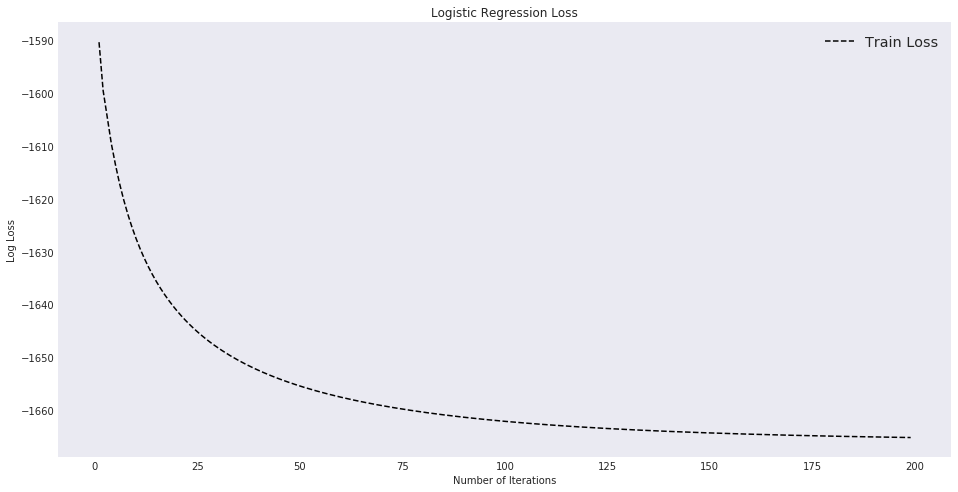

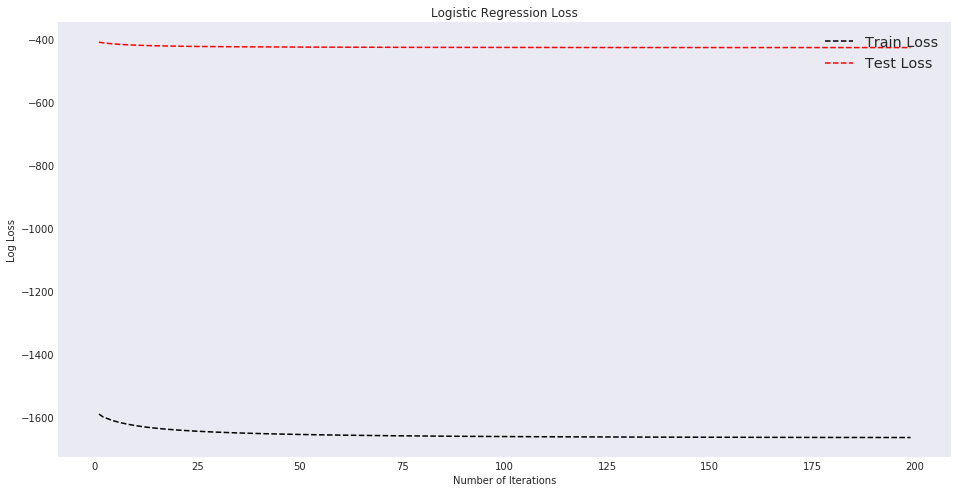

In [16]:
plotErrorCurves(TrainLogLoss, title = 'Logistic Regression Loss' )
plotErrorCurves(TrainLogLoss, testLoss = TestLogLoss, title = 'Logistic Regression Loss' )

In [17]:
#MLLib Validation
augTrainDF = trainRDD.map(lambda x: (x[0],Vectors.dense(x[1]))).toDF(['label', 'features'])
lr = LogisticRegression(maxIter=200, regParam=0, elasticNetParam=0)
lrModel = lr.fit(augTrainDF)

MLLibModelVector = np.append(np.array(lrModel.intercept),np.array(lrModel.coefficients))

modelMetrics(augTrain, augTest, MLLibModelVector)


Final Model Vector: [-1.23601324e-01  4.60256724e-02  8.05747328e-02  2.39986316e-01
 -2.28720732e-01 -3.92242964e-01 -3.71671649e-02 -2.68508628e-01
  3.41693741e-03  2.97237549e-01 -3.99142024e-01  0.00000000e+00
 -2.22846342e-01 -5.58009431e-02  1.30428853e-01  0.00000000e+00
  3.26273629e-01 -3.12014882e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.69282559e+00 -2.81497979e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]

Gradient Descent Training Error: 0.3727061256138537

 Prediction Metrics on Test Data
Accuracy: 0.629889669007021
Precision: 0.62882096069869
Recall: 0.5913757700205339
F1: 0.6095238095238095

Gradient Descent Final Model Log Loss on Train Data: -1666.2004708236368

Gradient Descent Final Model Log Loss on Test Data: -427.1263778768707


As with the toy sample, we also performed validation of our home-grown algorithm results using the LogisticRegression() function from MLLib on the 10K EDA sample.  The result was very suprising given that the model vector from the MLLib function is very different compared to the model vector from the home-grown gradient descent algorithm.  However, despite the differences in the model vector, all 4 metrics - Accuracy, Precision, Recall, and F1 are extremely similar between the two models.  The other result that is very surpising from the MLLib model is that many of the coefficients in the model vector are 0, even though we did not specify any regularization in the function.  Our only conclusion is that even in the absence of regularization, the MLLib function must perform some sort of averaging over training with different paritions of the data to create different model vectors and then achieves the final model vector through taking the average.  Despite the model vectors being so different, the similarities in prediction outcomes between the home-grown and MLLib models, as shown by similar 4 metrics, still confirms that the implementation of our gradient descent algorithm is mathematically correct. 

### Regularization

We began to attempt model optimization through adding regularization parameters. Our intention was to us L1 regularization for further features selection and then to use L2 regularization for better model generalization.  First we performed L1 regularization by calling the lasso regularization gradient descent calculation in our homegrown algorithm.  On the 10K EDA set, lasso regularization did not decrease any of the parameters to 0 after 200 iterations.  We also varied the regularization parameter to several different values, but was not able to see dramatic decreases in any of the model coefficients.  Ultimately, we did not believe there were any more features were could remove given these results from L1 regularization testing.  Given more time, we would have wanted to explore optimized features selection using L1 regularization on a larger subsample, perhaps ~500K. 


Final Model Vector: [ 2.28038812e-01  1.82396414e-03  1.51493731e-02  3.11418557e-02
 -1.51220195e-01 -3.13723116e-01  1.22688896e-03 -1.37373202e-01
 -1.99018330e-04  2.52751837e-01 -2.06224616e-01 -2.19611883e-02
  1.59144333e-03 -5.08911407e-02  4.12450902e-03 -2.19611883e-02
  1.40025176e-03 -1.47169440e-01 -2.19611883e-02 -2.19611883e-02
 -2.19611883e-02 -2.19611883e-02 -2.19611883e-02 -2.19611883e-02
  2.66316745e-03 -3.23623558e-02 -2.19611883e-02 -2.19611883e-02
 -2.19611883e-02]

Gradient Descent Training Error: 0.37193073145515637

 Prediction Metrics on Test Data
Accuracy: 0.6318956870611836
Precision: 0.6395348837209303
Recall: 0.5646817248459959
F1: 0.5997818974918212

Gradient Descent Final Model Log Loss on Train Data: -1639.0882385539253

Gradient Descent Final Model Log Loss on Test Data: -422.3740034619516


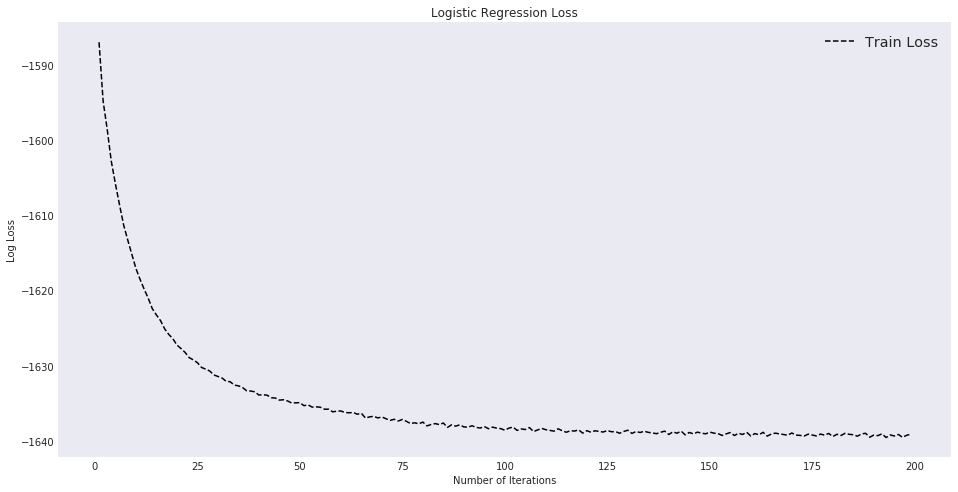

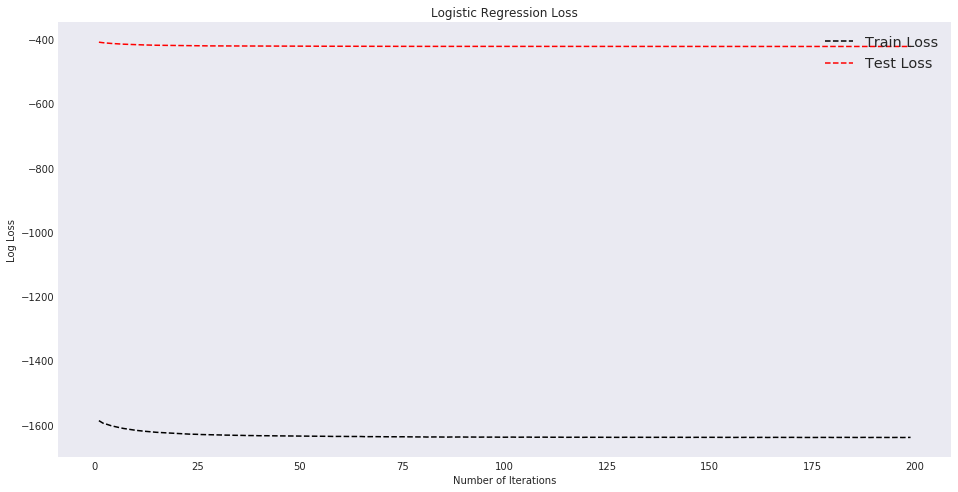

In [18]:
TrainLogLossL1, TestLogLossL1, ModelsL1 = GradientDescent(augTrain, wInit, testRDD = augTest, nSteps = 200, learningRate = 0.0001, regType = 'lasso', regParam = 0.01)
modelMetrics(augTrain, augTest, ModelsL1[-1])
plotErrorCurves(TrainLogLossL1, title = 'Logistic Regression Loss' )
plotErrorCurves(TrainLogLossL1, testLoss = TestLogLossL1, title = 'Logistic Regression Loss' )

We also attempted to find an optimal L2 regularization parameter for model generalization and to prevent overfitting.  In our L2 regularization testing, we used the visual queues from the train and test loss over iterations plots to determine if L2 regularization was helping our model.  Given the large difference between test and train losses, we believed that the model did not generalize well.  However, after many attempts at changing the ridge regularization parameter, we were not able to close the large distance between train and test losses.

Our initial conclusion was that 10K was simply not a large enough data set to optimize L2 parameter, as the train and test distributions sampled from 10K were too different.  However, later on in our ensemble model testing, we discovered that the real culprit was the difference in size of the train and test data.  Given our that our test subset is 1/5 the size of the train data set, and the log loss is a summation of loss over all data points, a larger data set produces a larger loss.  In our ensemble method shown later on, test and train sets of the same size have relatively similar loss values over iterations.  

It is very possible that our loss function used in algorithm formulation is missing a 1/N factor, where N is the number of rows.  In other words, instead of accumulating loss over the data points, we should be taking an average of the loss.  We did find literature towards the end of the project where log loss averages the loss over the data, however by the time we realized this, we no longer had sufficient time to change our algorithm.  _**We wanted to point out here that the original equations we used in our model formulation, where the 1/N factor is missing, was actually taken from the async slides**_.  Therefore, not averaging the log loss was intentional based on the information we had access to.  If we had more time, we would go back and change our algorithm to include average log loss, and explore L2 parameter optimization on a larger sample.


Final Model Vector: [ 0.16015844  0.04095857  0.0629407   0.1454778  -0.19890996 -0.33171475
  0.01844997 -0.21351621  0.00165817  0.24609313 -0.29950282 -0.03598242
 -0.08887339 -0.0461092   0.09900016 -0.03598242  0.18804292 -0.22402535
 -0.03598242 -0.03598242 -0.03598242 -0.03598242 -0.03598242 -0.03598242
  0.00514082 -0.04112324 -0.03598242 -0.03598242 -0.03598242]

Gradient Descent Training Error: 0.3703799431377617

 Prediction Metrics on Test Data
Accuracy: 0.633901705115346
Precision: 0.6412037037037037
Recall: 0.5687885010266941
F1: 0.6028291621327531

Gradient Descent Final Model Log Loss on Train Data: -1654.1222628267637

Gradient Descent Final Model Log Loss on Test Data: -424.88014438389564


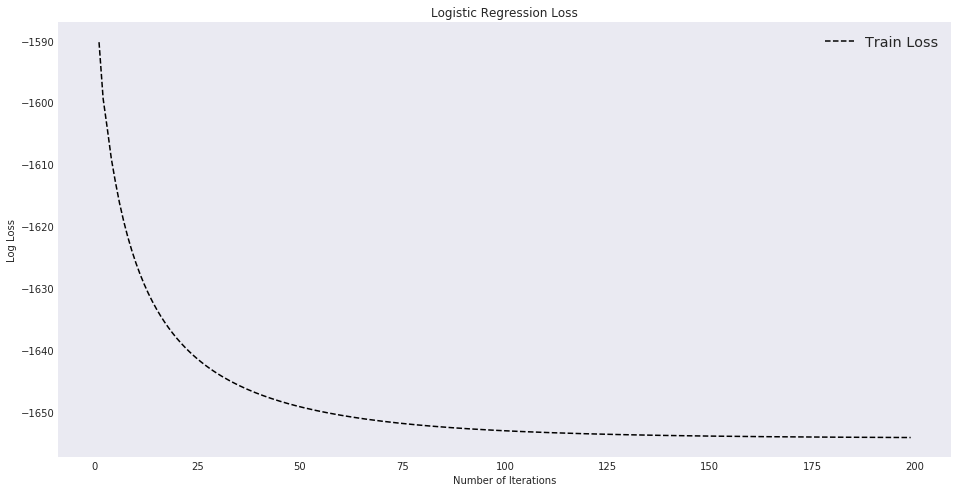

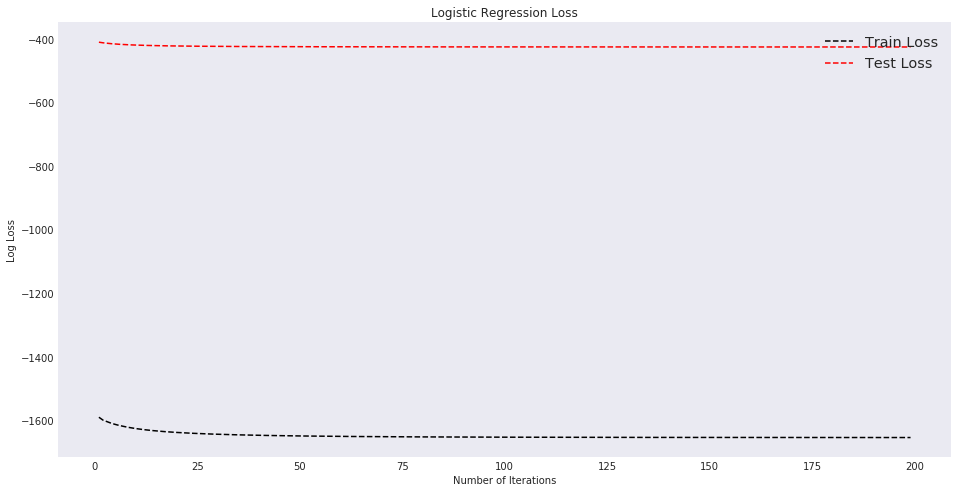

In [21]:
TrainLogLossL2, TestLogLossL2, ModelsL2 = GradientDescent(augTrain, wInit, testRDD = augTest, nSteps = 200, learningRate = 0.0001, regType = 'ridge', regParam = 0.01)
modelMetrics(augTrain, augTest, ModelsL2[-1])
plotErrorCurves(TrainLogLossL2, title = 'Logistic Regression Loss' )
plotErrorCurves(TrainLogLossL2, testLoss = TestLogLossL2, title = 'Logistic Regression Loss' )


### Implementing our algorithm in Google Cloud Platform

After testing the algorithm on both the toy dataset and the EDA dataset, we created a python script with the Spark jobs above to run in Google Cloud Platform (GCP) Dataproc. We ran an initial test of the implementation with the feature selection, pre-processing, and Gradient Descent algorithm on the EDA dataset with 1 master and 2 worker nodes, which was successful. However, as we attempted to run this on the full training dataset to build the model and perform prediction, our jobs failed likely due to the tasks becoming too large in the pre-processing step. We noticed that in particular, the categorical features selection would overwhelm the worker nodes and some rows were not processed in categorical feature selection, leading to dimensionality mismatch in row count between numerical features and categorical features when we tried to zip the two dataframes back togther prior to running gradient descent. Our original attempt to run in GCP using both numerical and categorical feature selection on the full data set is detailed here in the project repo 
    - https://github.com/UCB-w261/SU19-PROJECT-team21/blob/master/development_files/FinalAlgorithm.py


Due to time constraints, we decided to modify our GCP script to only process numerical features, since we knew the tasks for numeric feature selection would not overwhelm the worker nodes.  This decision did not match our original intentions, as we knew that categorical features are paramount to algorithm training and predictions.  However, given that we ran out of time to optimize categorical feature selection for larger data set, we decided to run the gradient descent algorithm on only numerical features to show that our main home-grown algorithm is indeed scalable over larger data sets.  Our initial attempt to train a Logistic Regression model on only numeric features was successful on ~10 million rows (20%) of the raw data within GCP. Our numeric columns algorithm does remove features 1, 10 and 12 due to their high percentage of null values seen in the EDA. The details of the intial attempt can be found in this file - 
    - https://github.com/UCB-w261/SU19-PROJECT-team21/blob/master/FinalAlgorithm_Numeric_1.py
    
Given the constraints with GCP, we found that attempting to process the entire train set of ~45 million rows is nearly impossible.  Since we knew that 20% can be processed successfully, we decided to partition the raw train data into 5 parts and developed our own ensemble algorithm to run gradient descent on numeric columns of the entire data.  In the ensemble method, we partition the data set 5 times, such that the first 4 paritions will be used to train 4 indpendent logistic regression models using the home-grown gradient descent algorithm.  The final model vector is the average of the 4 model vectors from the paritions.  The remaining 5th parition is the test set used for measure the performance of the final model vector.  Before running in GCP, we run this ensemble algorithm on the 10K EDA set in the cells below.  The final ensemble algorithm we submitted to GCP is found here -
    - https://github.com/UCB-w261/SU19-PROJECT-team21/blob/master/FinalAlgorithm_Numeric_Ensemble.py
    




### Ensemble

In [22]:
def processNumeric(dataRDD):
    '''takes input rdd and extracts only numeric columns
    then processes the numeric columns with imputation for null values and standard scaling
    outputs RDD ready for gradient descent algorithm evaluation'''
    
    dataDF = dataRDD.map(lambda x: x.split('\t'))\
            .map(lambda x: x[:14])\
            .map(lambda x: list(map(lambda y: float(y) if y!='' else None, x)))\
            .toDF()
    
    #drop features with the most missing values
    dataDF = dataDF.drop('_2','_11','_13')


    imputedDataDF = imputeNumeric(dataDF, 11)
    scaledDataDF =  scaleFeatures(imputedDataDF, 11)

    return scaledDataDF.rdd


rawTrainRDD = sc.parallelize(ast.literal_eval(open("eda.txt", "r").read()))
#rawTestRDD = ast.literal_eval(open("data/test.txt", "r").read())

#specify number of paritions
splitNum = 5
dataSplits = rawTrainRDD.randomSplit([1.0/float(splitNum) for i in range(splitNum)], seed = 2018)

#last split used as test data
rtestRDD = dataSplits[-1]
testRDD = processNumeric(rtestRDD)
#Transform test for Gradient Descent Processing
#Transform y-values in the following way for compatibility with gradient descent function - 
### y = 1 -> y' = 1
### y = 0 -> y' = -1
transformedTest = testRDD.map(lambda x: (2*x[0]-1, np.array(x[1]))).cache()
augTest = transformedTest.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()

wInit = np.array([0.25] + [0 for i in range(augTest.take(1)[0][1].shape[0]-1)])

ensembleModels = wInit
trainLossHistory = []
testLossHistory = []


for rdd in dataSplits[:splitNum-1]:
    trainRDD = processNumeric(rdd)
    
    #Transform Train Partition for Gradient Descent Processing
    #Transform y-values in the following way for compatibility with gradient descent function - 
    ### y = 1 -> y' = 1
    ### y = 0 -> y' = -1
    transformedTrain = trainRDD.map(lambda x: (2*x[0]-1, np.array(x[1]))).cache()
    
    #apply augmentation
    augTrain = transformedTrain.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()

    #Run gradient descent algorithm
    start = time.time()

    #in GCP:
    #TrainLogLoss, TestLogLoss, Models = GradientDescent(augTrain, wInit, testRDD = augTest, nSteps = 500, learningRate = 0.000001)

    #in notebook
    TrainLogLoss, TestLogLoss, Models = GradientDescent(augTrain, wInit, testRDD = augTest, nSteps = 200, learningRate = 0.0001)

    print(f"\n... trained {len(Models)} iterations in {time.time() - start} seconds")
    
    ensembleModels = np.vstack((ensembleModels, Models[-1]))
    trainLossHistory.append(TrainLogLoss)
    testLossHistory.append(TestLogLoss)

    
#final model is an average of the partition models
ensembleModel = np.mean(ensembleModels[1:], axis = 0)

#prediction methods of ensembleModel on the test set
#can only caculate training error on the last train set
modelMetrics(augTrain, augTest, ensembleModel)


... trained 200 iterations in 127.46779131889343 seconds

... trained 200 iterations in 92.54715633392334 seconds

... trained 200 iterations in 146.4651072025299 seconds

... trained 200 iterations in 146.8055853843689 seconds

Final Model Vector: [-1.20690842  0.07472463  0.01802024  0.13822854 -0.24907997 -0.41509244
 -0.00383477 -0.12237154 -0.00287824  0.28159911 -0.3927999 ]

Gradient Descent Training Error: 0.2471290767110703

 Prediction Metrics on Test Data
Accuracy: 0.7165389815232086
Precision: 0.5833333333333334
Recall: 0.03307086614173228
F1: 0.06259314456035767

Gradient Descent Final Model Log Loss on Train Data: -1064.863489853071

Gradient Descent Final Model Log Loss on Test Data: -1057.025253314701


We also plot the train and test losses over iterations for each of the 4 paritions below.  In this plots, we realized that loss values are more similar due to the data sets being of similar size.  This is where we began to suspect hat our log loss objective function may have been missing a 1/N factor for averaging log loss over the data points

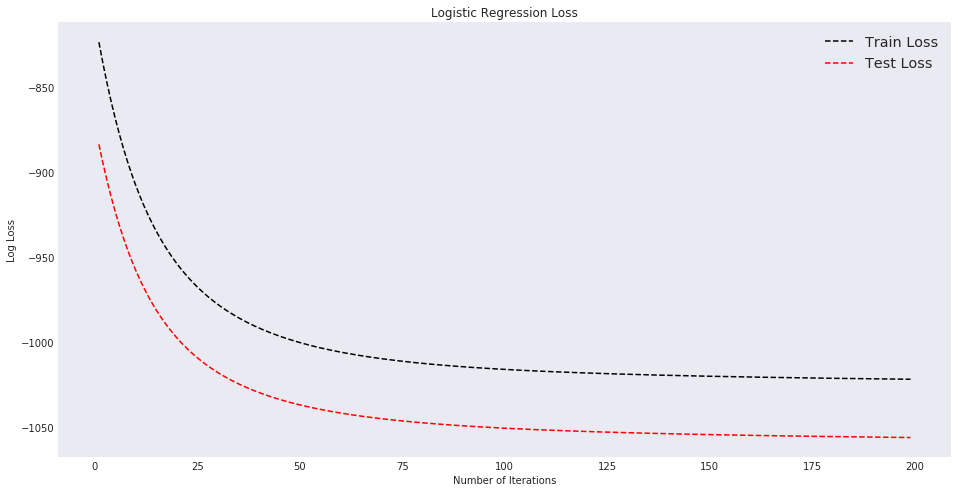

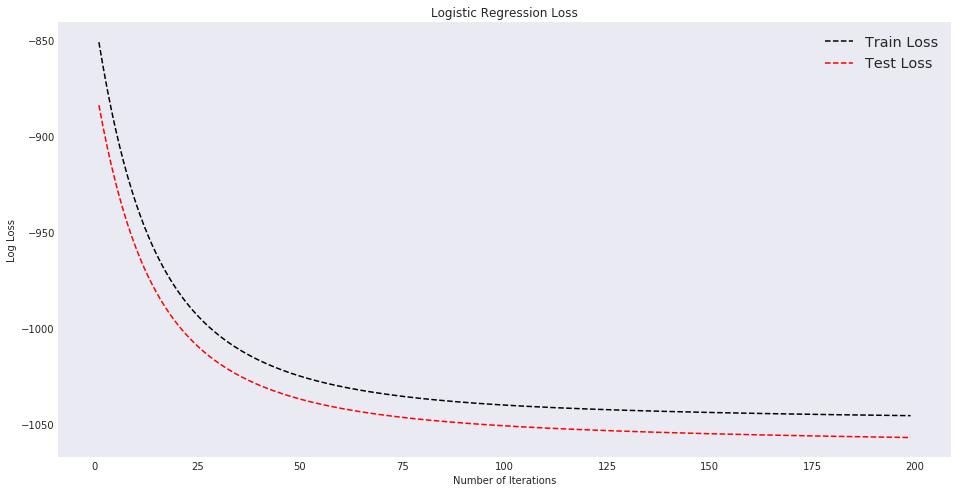

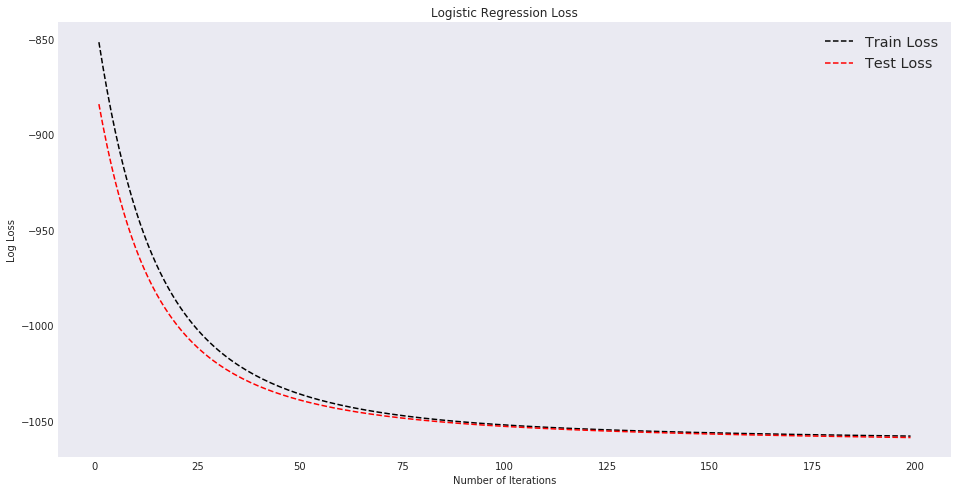

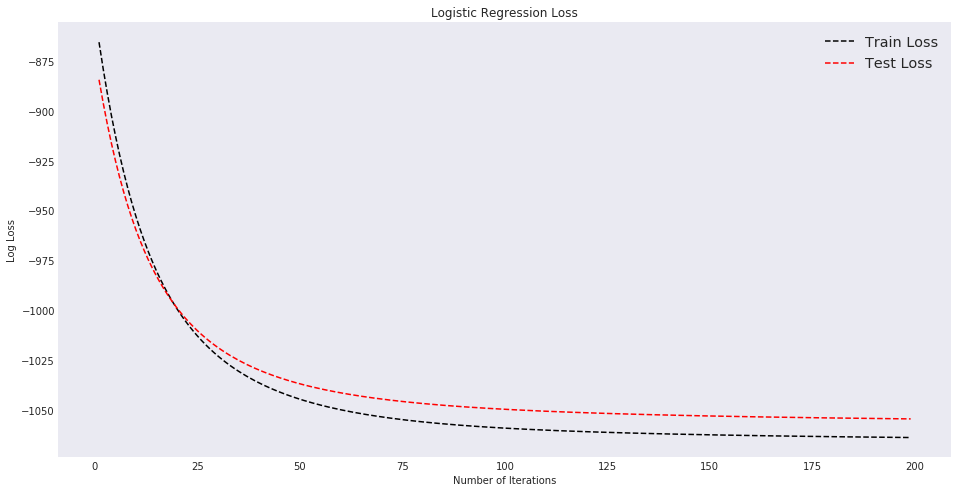

In [26]:
for i in range(splitNum - 1):
    plotErrorCurves(trainLossHistory[i], testLoss = testLossHistory[i],  title = 'Logistic Regression Loss' )

### Final Model Results

### Brief Discussion on Errors

|Performance Metric|Numeric Features Only Algorithm|Numeric + Categorical Features Algorithm|
|---|---|---|
|Accuracy | 0.7165389815232086|0.629889669007021|
|Precision| 0.5833333333333334|0.62882096069869|
|Recall | 0.03307086614173228|0.5913757700205339|
|F1| 0.06259314456035767|0.6095238095238095|



While neither of our algorithm versions were fully optimized, or entirely ideal, we were supprized to to find that our algorithm developed from training on only numeric features significantly outperformed the algorithm trained on both numberic and categorical features in predicting test label accuracy.  However, the Recall and F1 score of the numerical features only algorithm is very terrible.  The low recall score must mean that we have a large number of false negatives in our predictons.  In fact, in order for the recall to be this low, the number of false negatives must far exceed the number of true positives.  Furthermore, in the numerical features only algorith, the precision is close to 50% which indicates that the number of false positives is almost equivalent to the number of true positives.  This means that false negatives far outweight the false positives in the numeric only algorithm.  

For CTR predictions, having more false negatives rather than false positives may be slightly more desireable, since high false positives lead to setting unrealistic business expectations while false negatives allow for safer performance projections.  However, in the case of the numeric features only algorithm, the low Recall score, which also causes the low F1 score signifies that the false negative to true positive ratio is far too high.  The accuracy increase compared to the model using both numeric and categorical features indicates that the majority of accuracies must come from predicting negative outcomes, or no clicks. We see from the results here that while accuracy increases, it only means that the numeric only algorithm is very good at predicting negative outcomes but extremely poor at predicting positive outcomes.  This is further indication that the categoircal features are paramount to the prediction process, and given more time, our first step will be to optimize categorical feature selection for scalability.

In the plot below, we show the log loss from the first and thrid iterations of our GCP ensemble algorithm.  This is an excellent indicator that our first parition algorithm training was able to acheive convergence. 

In [41]:
trainloss2 = [-3547903.166736123, -3572207.7358835298, -3595779.2344773435, -3618633.4545881194, -3640786.1910119085, -3662253.4283175217, -3683051.494655554, -3703197.0918173688, -3722707.250524908, -3741599.252374348, -3759890.5409246157, -3777598.6329960003, -3794741.0354142003, -3811335.1695273863, -3827398.3043483705, -3842947.4984055287, -3857999.5499790697, -3872570.955189298, -3886677.8732994613, -3900336.098558471, -3913561.037908101, -3926367.693901613, -3938770.6522168196, -3950784.0731900986, -3962421.686844416, -3973696.7909318, -3984622.2515578545, -3995210.5060004666, -4005473.5673761545, -4015423.0308485567, -4025070.0811071177, -4034425.5008789967, -4043499.68026562, -4052302.626722711, -4060843.975526621, -4069133.0005908003, -4077178.625516005, -4084989.4347742116, -4092573.684941251, -4099939.3159064953, -4107093.961999169, -4114044.962981329, -4120799.3748656847, -4127363.9805254876, -4133745.3000682527, -4139949.600953117, -4145982.907834804, -4151851.012122658, -4157559.4812458823, -4163113.667620178, -4168518.71731282, -4173779.578405816, -4178901.009058735, -4183887.585274261, -4188743.708370326, -4193473.612164781, -4198081.369878381, -4202570.900762855, -4206945.976462004, -4211210.227112589, -4215367.1471941825, -4219420.101134953, -4223372.328682948, -4227226.9500499, -4230986.970836917, -4234655.286749801, -4238234.688111905, -4241727.864183038, -4245137.407291822, -4248465.816789226, -4251715.502830626, -4254888.789993915, -4257987.920739932, -4261015.058722873, -4263972.291956409, -4266861.635842218, -4269685.036066844, -4272444.3713727165, -4275141.456208888, -4277778.043266883, -4280355.825906844, -4282876.440478706, -4285341.4685434885, -4287752.438998703, -4290110.830112751, -4292418.071471973, -4294675.545844632, -4296884.590965338, -4299046.50124376, -4301162.529400814, -4303233.88803577, -4305261.751127513, -4307247.255472446, -4309191.502062691, -4311095.5574064255, -4312960.454793624, -4314787.195509231, -4316576.749996441, -4318330.058972172, -4320048.034496661, -4321731.560999893, -4323381.496265671, -4324998.672376678, -4326583.896620727, -4328137.95236113, -4329661.599872067, -4331155.5771407075, -4332620.600637647, -4334057.366056836, -4335466.549026544, -4336848.805792239, -4338204.7738732975, -4339535.072693742, -4340840.304189029, -4342121.053389293, -4343377.88898021, -4344611.3638427, -4345822.015571989, -4347010.3669769475, -4348176.926561018, -4349322.188984774, -4350446.635511339, -4351550.734435474, -4352634.941496541, -4353699.700276398, -4354745.442582785, -4355772.5888187075, -4356781.548338321, -4357772.719790193, -4358746.491447989, -4359703.241529486, -4360643.338504215, -4361567.1413900675, -4362475.00003974, -4363367.255416787, -4364244.239862184, -4365106.277351658, -4365953.683744076, -4366786.767021306, -4367605.827519664, -4368411.158153829, -4369203.044632812, -4369981.765668883, -4370747.593179197, -4371500.792481, -4372241.6224800525, -4372970.33585308, -4373687.179223831, -4374392.393333828, -4375086.213207115, -4375768.868309961, -4376440.582705313, -4377101.575202189, -4377752.059500397, -4378392.244330577, -4379022.333590001, -4379642.526473869, -4380253.0176025005, -4380853.997144677, -4381445.650937377, -4382028.160601019, -4382601.703652258, -4383166.453612314, -4383722.580112689, -4384270.248997287, -4384809.622421586, -4385340.858948651, -4385864.113642477, -4386379.538158065, -4386887.28082922, -4387387.4867533045, -4387880.29787343, -4388365.853058139, -4388844.28817866, -4389315.7361834245, -4389780.327170369, -4390238.188456998, -4390689.444647967, -4391134.217700337, -4391572.626987111, -4392004.78935819, -4392430.8191997465, -4392850.828491396, -4393264.926862016, -4393673.2216433715, -4394075.817922861, -4394472.818594273, -4394864.324407833, -4395250.434018751, -4395631.244034855, -4396006.849063278, -4396377.341756258, -4396742.81285605, -4397103.351239071, -4397459.04395908, -4397809.976289588, -4398156.231765379, -4398497.892223049, -4398835.037840618, -4399167.747176019, -4399496.097204768, -4399820.163356281, -4400140.019549487, -4400455.73822709, -4400767.390388828, -4401075.045623799, -4401378.772141895, -4401678.636803895, -4401974.705151142, -4402267.041434046, -4402555.708639857, -4402840.768519845, -4403122.281615551, -4403400.3072846215, -4403674.903725821, -4403946.128003712, -4404214.03607276, -4404478.682800751, -4404740.121992059, -4404998.406410212, -4405253.587800254, -4405505.716910426, -4405754.843513832, -4406001.016429323, -4406244.283542087, -4406484.691824139, -4406722.2873540865, -4406957.11533651, -4407189.220121214, -4407418.645221923, -4407645.433334396, -4407869.626354625, -4408091.265396075, -4408310.390806988, -4408527.042186928, -4408741.25840321, -4408953.077606721, -4409162.537247578, -4409369.6740900325, -4409574.524227448, -4409777.123096446, -4409977.505491096, -4410175.705576325, -4410371.756901403, -4410565.692412638, -4410757.544466169, -4410947.344840014, -4411135.124746096, -4411320.914841805, -4411504.745241376, -4411686.645526825, -4411866.644758691, -4412044.771486522, -4412221.053759137, -4412395.5191343855, -4412568.194688985, -4412739.107028073, -4412908.282294137, -4413075.746176361, -4413241.523919196, -4413405.640331153, -4413568.119793015, -4413728.986266205, -4413888.263300677, -4414045.974042977, -4414202.141243685, -4414356.787265043, -4414509.934088386, -4414661.603321105, -4414811.816203922, -4414960.593617674, -4415107.956090102, -4415253.923802351, -4415398.516595567, -4415541.753977186, -4415683.655127094, -4415824.238903752, -4415963.523850142, -4416101.528199642, -4416238.269881565, -4416373.766526935, -4416508.035473953, -4416641.093773233, -4416772.958193156, -4416903.645225057, -4417033.1710881805, -4417161.551734791, -4417288.802854753, -4417414.939880606, -4417539.977991896, -4417663.93212005, -4417786.816952662, -4417908.646937884, -4418029.436288794, -4418149.198987579, -4418267.948789644, -4418385.699227712, -4418502.463615793, -4418618.255052981, -4418733.086427371, -4418846.970419793, -4418959.919507394, -4419071.945967429, -4419183.06188049, -4419293.279134338, -4419402.609426949, -4419511.0642700605, -4419618.65499241, -4419725.392742819, -4419831.288493535, -4419936.353043094, -4420040.597019493, -4420144.0308832405, -4420246.664929941, -4420348.509293513, -4420449.573948799, -4420549.868714358, -4420649.403255191, -4420748.187085342, -4420846.2295705555, -4420943.539930788, -4421040.127242682, -4421136.000442193, -4421231.168326669, -4421325.639557669, -4421419.422662879, -4421512.52603866, -4421604.957952126, -4421696.7265434, -4421787.839827898, -4421878.3056982355, -4421968.131926404, -4422057.326165925, -4422145.89595359, -4422233.848711764, -4422321.191750058, -4422407.932267326, -4422494.077353532, -4422579.633991588, -4422664.609059146, -4422749.009330291, -4422832.841477477, -4422916.112072958, -4422998.8275906695, -4423080.994407814, -4423162.618806428, -4423243.706975083, -4423324.265010207, -4423404.298917951, -4423483.814615346, -4423562.8179321, -4423641.314611762, -4423719.31031334, -4423796.810612606, -4423873.821003494, -4423950.34689954, -4424026.393634936, -4424101.966466251, -4424177.070573212, -4424251.711060465, -4424325.8929584585, -4424399.621224725, -4424472.900745256, -4424545.736335357, -4424618.132741155, -4424690.094640398, -4424761.626643823, -4424832.733296087, -4424903.419076897, -4424973.688402103, -4425043.545624629, -4425112.9950356055, -4425182.040865325, -4425250.687284145, -4425318.9384036, -4425386.798277244, -4425454.27090165, -4425521.360217289, -4425588.070109344, -4425654.404408829, -4425720.366893207, -4425785.961287415, -4425851.19126464, -4425916.060447101, -4425980.572406998, -4426044.7306670975, -4426108.538701814, -4426171.999937621, -4426235.117754112, -4426297.895484633, -4426360.336417001, -4426422.443794177, -4426484.220815063, -4426545.670635255, -4426606.796367489, -4426667.601082587, -4426728.087809923, -4426788.259538177, -4426848.119215962, -4426907.669752361, -4426966.914017652, -4427025.85484391, -4427084.495025547, -4427142.837319898, -4427200.884447887, -4427258.639094419, -4427316.103909206, -4427373.281507011, -4427430.1744683925, -4427486.785340218, -4427543.1166361235, -4427599.170837002, -4427654.9503916, -4427710.457716927, -4427765.695198833, -4427820.665192427, -4427875.370022489, -4427929.811984126, -4427983.993342963, -4428037.916335872, -4428091.583171178, -4428144.996029238, -4428198.157062808, -4428251.06839742, -4428303.7321319245, -4428356.1503388155, -4428408.325064564, -4428460.258330144, -4428511.952131301, -4428563.408439054, -4428614.629199941, -4428665.616336485, -4428716.371747424, -4428766.897308321, -4428817.194871617, -4428867.266267131, -4428917.1133024115, -4428966.737762989, -4429016.1414128095, -4429065.325994429, -4429114.293229382, -4429163.044818601, -4429211.582442551, -4429259.907761609, -4429308.022416428, -4429355.928028007, -4429403.626198351, -4429451.118510351, -4429498.406528312, -4429545.491798166, -4429592.375847719, -4429639.060186944, -4429685.5463082325, -4429731.835686586, -4429777.929780004, -4429823.830029619, -4429869.537860014, -4429915.05467935, -4429960.381879733, -4430005.520837435, -4430050.472912954, -4430095.239451484, -4430139.821782954, -4430184.2212223355, -4430228.439069818, -4430272.476611029, -4430316.335117248, -4430360.015845635, -4430403.52003936, -4430446.84892791, -4430490.0037270915, -4430532.985639542, -4430575.795854541, -4430618.435548496, -4430660.905884962, -4430703.20801488, -4430745.3430768065, -4430787.312196918, -4430829.116489329, -4430870.757056269, -4430912.234988163, -4430953.551363839, -4430994.707250689, -4431035.7037048, -4431076.541771143, -4431117.222483783, -4431157.74686585, -4431198.115929882, -4431238.3306778725, -4431278.3921013735, -4431318.301181795, -4431358.058890396, -4431397.66618847, -4431437.12402751, -4431476.433349236, -4431515.595085966, -4431554.610160391, -4431593.479486064, -4431632.203967223, -4431670.784499148, -4431709.221968124, -4431747.517251654, -4431785.671218533, -4431823.68472899, -4431861.5586347105, -4431899.293779108, -4431936.890997349, -4431974.351116423, -4432011.674955286, -4432048.863325025, -4432085.91702886, -4432122.836862305, -4432159.62361333, -4432196.278062206, -4432232.800981996, -4432269.193138347, -4432305.455289674, -4432341.588187257, -4432377.592575349, -4432413.4691912765, -4432449.218765474, -4432484.842021625, -4432520.3396767005, -4432555.712441077, -4432590.961018644, -4432626.086106869, -4432661.088396784, -4432695.96857324, -4432730.727314882, -4432765.36529415, -4432799.883177617, -4432834.2816257095, -4432868.561293132, -4432902.722828674, -4432936.766875385, -4432970.694070719, -4433004.505046444, -4433038.20042889, -4433071.780838851, -4433105.246891733, -4433138.5991977, -4433171.8383615175, -4433204.964982841, -4433237.979656231, -4433270.88297108, -4433303.675511808, -4433336.35785788, -4433368.930583893, -4433401.39425963, -4433433.749450019, -4433465.996715376, -4433498.136611304, -4433530.169688766, -4433562.096494249, -4433593.917569687, -4433625.63345261, -4433657.244676142, -4433688.751769072, -4433720.155255911, -4433751.455656917, -4433782.653488161, -4433813.749261629, -4433844.743485108, -4433875.636662438, -4433906.4292934155, -4433937.121873934, -4433967.714895955, -4433998.208847517, -4434028.604212968, -4434058.901472773, -4434089.101103724, -4434119.203578946, -4434149.209367857, -4434179.11893628, -4434208.9327465445, -4434238.6512573585, -4434268.2749240855, -4434297.804198434, -4434327.239528905, -4434356.581360536, -4434385.83013502, -4434414.986290827, -4434444.050263048, -4434473.022483703, -4434501.903381519, -4434530.693382086, -4434559.392907907, -4434588.002378338, -4434616.522209788, -4434644.9528155215, -4434673.294605912, -4434701.547988364, -4434729.713367322, -4434757.791144337, -4434785.781718133, -4434813.685484619, -4434841.502836844, -4434869.234165109, -4434896.879857018, -4434924.440297387]

In [42]:
testloss2 = [-3550561.2329195184, -3574885.917548579, -3598477.325054744, -3621350.948521519, -3643522.468053676, -3665007.8043312435, -3685823.2497065086, -3705985.490011218, -3725511.5542795314, -3744418.732570547, -3762724.484070021, -3780446.346242939, -3797601.850017873, -3814208.443146922, -3830283.422471677, -3845843.8750997856, -3860906.6281199204, -3875488.2062863144, -3889604.797012562, -3903272.2219810984, -3916505.914679104, -3929320.903195718, -3941731.797654299, -3953752.781698115, -3965397.607495551, -3976679.5937801157, -3987611.6264879503, -3998206.161601108, -4008475.2298478005, -4018430.4429501235, -4028083.001146967, -4037443.701752473, -4046522.948540551, -4055330.7617732626, -4063876.7887154263, -4072170.3144982294, -4080220.273215378, -4088035.2591514266, -4095623.5380569063, -4102993.0583986305, -4110151.462524499, -4117106.097693095, -4123864.0269261873, -4130432.0396506414, -4136816.6621031975, -4143024.167475985, -4149060.585787746, -4154931.713467498, -4160643.122643499, -4166200.1701316745, -4171608.006120864, -4176871.582555277, -4181995.6612147153, -4186984.821496659, -4191843.467903792, -4196575.837242675, -4201186.00554016, -4205677.894683682, -4210055.278793679, -4214321.790335298, -4218480.925977838, -4222536.05221005, -4226490.410719517, -4230347.123544784, -4234109.1980081955, -4237779.5314380955, -4241360.915687979, -4244856.04146154, -4248267.502450332, -4251597.799292416, -4254849.343359422, -4258024.460378874, -4261125.393898835, -4264154.308602282, -4267113.293476688, -4270004.364845955, -4272829.469270458, -4275590.486320886, -4278289.231231779, -4280927.457439991, -4283506.859013047, -4286029.072972761, -4288495.681518383, -4290908.214154178, -4293268.149725477, -4295576.918367641, -4297835.903371357, -4300046.442968839, -4302209.832043799, -4304327.323769039, -4306400.1311747795, -4308429.428651081, -4310416.353386803, -4312362.006748949, -4314267.455603823, -4316133.733583854, -4317961.842301518, -4319752.752513499, -4321507.405236803, -4323226.712819306, -4324911.559966507, -4326562.804726751, -4328181.279436308, -4329767.79162667, -4331323.124895247, -4332848.039741197, -4334343.274368156, -4335809.5454552, -4337247.5488968985, -4338657.960514963, -4340041.436741437, -4341398.61527573, -4342730.115715713, -4344036.540164839, -4345318.473815683, -4346576.485511089, -4347811.12828416, -4349022.9398775045, -4350212.4432429755, -4351380.147022556, -4352526.546011393, -4353652.1216033045, -4354757.342219974, -4355842.663724134, -4356908.529817727, -4357955.37242527, -4358983.612063412, -4359993.6581970565, -4360985.9095825525, -4361960.754598599, -4362918.571565314, -4363859.729051975, -4364784.586173639, -4365693.492877724, -4366586.790220006, -4367464.810631275, -4368327.878174853, -4369176.308794713, -4370010.410555449, -4370830.4838739615, -4371636.821743095, -4372429.709947614, -4373209.427273236, -4373976.245708233, -4374730.430638485, -4375472.241035988, -4376201.92964107, -4376919.743138654, -4377625.922328765, -4378320.702291268, -4379004.312545515, -4379676.977204637, -4380338.915124931, -4380990.340050501, -4381631.460753205, -4382262.481168329, -4382883.600525726, -4383495.013477054, -4384096.910219108, -4384689.476613043, -4385272.894300226, -4385847.340814274, -4386412.989690032, -4386970.010568831, -4387518.569301095, -4388058.828045374, -4388590.945365, -4389115.076321653, -4389631.372566605, -4390139.982429302, -4390641.051004072, -4391134.720234722, -4391621.128997936, -4392100.413185693, -4392572.705787458, -4393038.13697355, -4393496.834180919, -4393948.922203086, -4394394.523286701, -4394833.757237118, -4395266.741533008, -4395693.591447868, -4396114.420163921, -4396529.338848111, -4396938.456629984, -4397341.880397604, -4397739.714342263, -4398132.059297473, -4398519.012147546, -4398900.665772218, -4399277.109851063, -4399648.43229494, -4400014.720567596, -4400376.062257738, -4400732.544845679, -4401084.25506485, -4401431.278283688, -4401773.69811108, -4402111.596229995, -4402445.0523838, -4402774.144439353, -4403098.948476354, -4403419.538878116, -4403735.988412931, -4404048.368304339, -4404356.748290767, -4404661.196676518, -4404961.780376511, -4405258.564955606, -4405551.614664552, -4405840.992472951, -4406126.760099985, -4406408.978043557, -4406687.705608059, -4406963.000931079, -4407234.921009096, -4407503.521722657, -4407768.857860643, -4408030.983144118, -4408289.95024982, -4408545.810832822, -4408798.615549197, -4409048.414078111, -4409295.255143497, -4409539.186535393, -4409780.2551310705, -4410018.506915468, -4410253.987001511, -4410486.739649974, -4410716.808288744, -4410944.235531978, -4411169.063198518, -4411391.332329918, -4411611.083208235, -4411828.355373046, -4412043.18763815, -4412255.618107665, -4412465.68419196, -4412673.422622591, -4412878.869467393, -4413082.06014458, -4413283.029436647, -4413481.811503918, -4413678.439897497, -4413872.94757188, -4414065.366897243, -4414255.729671363, -4414444.067130945, -4414630.409963075, -4414814.788315921, -4414997.231809367, -4415177.769545293, -4415356.430117555, -4415533.24162184, -4415708.231665111, -4415881.4273749385, -4416052.8554085, -4416222.541961627, -4416390.512777297, -4416556.793154258, -4416721.407955169, -4416884.381614961, -4417045.738148654, -4417205.501159146, -4417363.693845096, -4417520.339008181, -4417675.459060596, -4417829.07603237, -4417981.211578242, -4418131.886984856, -4418281.123177462, -4418428.940726679, -4418575.359855034, -4418720.400443492, -4418864.08203773, -4419006.423854376, -4419147.444787133, -4419287.163412726, -4419425.597996876, -4419562.766499829, -4419698.686582312, -4419833.375610799, -4419966.850663078, -4420099.12853359, -4420230.225738578, -4420360.158521213, -4420488.942856644, -4420616.594456852, -4420743.128775544, -4420868.561012826, -4420992.906119783, -4421116.17880312, -4421238.393529495, -4421359.564529966, -4421479.705804087, -4421598.831124349, -4421716.954040033, -4421834.087881294, -4421950.24576324, -4422065.440589492, -4422179.685056288, -4422292.991655824, -4422405.3726802515, -4422516.840224983, -4422627.406192288, -4422737.082294597, -4422845.88005798, -4422953.810825345, -4423060.885759758, -4423167.115847377, -4423272.511900897, -4423377.08456222, -4423480.844305627, -4423583.801440753, -4423685.966115209, -4423787.3483176995, -4423887.957880509, -4423987.804482361, -4424086.89765105, -4424185.246765925, -4424282.861060642, -4424379.749625527, -4424475.921410018, -4424571.385225201, -4424666.1497460455, -4424760.223513831, -4424853.614938342, -4424946.332300185, -4425038.3837529225, -4425129.777325301, -4425220.520923244, -4425310.622332132, -4425400.089218588, -4425488.929132717, -4425577.149509959, -4425664.757672984, -4425751.760833715, -4425838.166095128, -4425923.980452958, -4426009.210797783, -4426093.863916474, -4426177.9464941695, -4426261.465115842, -4426344.426267955, -4426426.836340292, -4426508.701627351, -4426590.028330021, -4426670.822557166, -4426751.090327067, -4426830.837569058, -4426910.070124842, -4426988.793750063, -4427067.014115698, -4427144.7368094465, -4427221.967337035, -4427298.711123708, -4427374.973515452, -4427450.759780336, -4427526.0751097435, -4427600.924619728, -4427675.313352181, -4427749.246275995, -4427822.728288361, -4427895.764215891, -4427968.358815752, -4428040.516776871, -4428112.242720958, -4428183.541203599, -4428254.4167153975, -4428324.873683035, -4428394.916470247, -4428464.549378783, -4428533.776649612, -4428602.602463741, -4428671.030943214, -4428739.066152013, -4428806.712097115, -4428873.972729417, -4428940.851944409, -4429007.353583287, -4429073.481433825, -4429139.239231049, -4429204.630658215, -4429269.659347679, -4429334.328881583, -4429398.642792705, -4429462.604565264, -4429526.21763569, -4429589.485393391, -4429652.411181416, -4429714.998297349, -4429777.24999382, -4429839.169479393, -4429900.759919197, -4429962.024435623, -4430022.966108875, -4430083.58797789, -4430143.893040776, -4430203.884255458, -4430263.56454045, -4430322.936775285, -4430382.003801369, -4430440.768422308, -4430499.233404649, -4430557.4014784675, -4430615.275337812, -4430672.857641436, -4430730.151013225, -4430787.15804272, -4430843.88128575, -4430900.323264917, -4430956.486470046, -4431012.373358725, -4431067.986356888, -4431123.327859102, -4431178.400229273, -4431233.205801016, -4431287.74687802, -4431342.025734731, -4431396.044616567, -4431449.805740497, -4431503.311295485, -4431556.563442802, -4431609.564316562, -4431662.316024068, -4431714.8206463, -4431767.080238106, -4431819.09682894, -4431870.872422881, -4431922.408999268, -4431973.708512955, -4432024.772894747, -4432075.604051654, -4432126.203867434, -4432176.574202751, -4432226.716895511, -4432276.633761445, -4432326.326594207, -4432375.797165709, -4432425.047226676, -4432474.078506609, -4432522.892714407, -4432571.491538454, -4432619.8766470915, -4432668.049688874, -4432716.012292684, -4432763.766068284, -4432811.31260644, -4432858.653479227, -4432905.790240295, -4432952.724425172, -4432999.457551564, -4433045.991119444, -4433092.326611556, -4433138.465493378, -4433184.4092137115, -4433230.15920464, -4433275.716881821, -4433321.083644951, -4433366.260877603, -4433411.249947823, -4433456.052208158, -4433500.668995888, -4433545.101633398, -4433589.351428111, -4433633.419672981, -4433677.307646534, -4433721.016613168, -4433764.547823243, -4433807.902513323, -4433851.081906531, -4433894.08721245, -4433936.91962753, -4433979.580335203, -4434022.07050605, -4434064.391298021, -4434106.54385661, -4434148.529314909, -4434190.348794007, -4434232.003402988, -4434273.494239115, -4434314.8223879775, -4434355.988923874, -4434396.994909531, -4434437.84139681, -4434478.529426312, -4434519.0600279365, -4434559.434220838, -4434599.653013633, -4434639.717404513, -4434679.628381369, -4434719.386922042, -4434758.993994314, -4434798.450556137, -4434837.757555715, -4434876.915931719, -4434915.926613314, -4434954.790520309, -4434993.508563393, -4435032.081644035, -4435070.5106548965, -4435108.796479648, -4435146.939993305, -4435184.942062331, -4435222.803544551, -4435260.525289514, -4435298.108138499, -4435335.552924538, -4435372.860472681, -4435410.031599983, -4435447.067115708, -4435483.9678213205, -4435520.734510667, -4435557.367970043, -4435593.868978292, -4435630.238306947, -4435666.4767202, -4435702.5849752305, -4435738.5638220105, -4435774.414003566, -4435810.136256088, -4435845.731308913, -4435881.199884751, -4435916.542699517, -4435951.7604627665, -4435986.853877503, -4436021.823640384, -4436056.67044168, -4436091.39496555, -4436125.997890007, -4436160.479886949, -4436194.841622311, -4436229.083756089, -4436263.206942494, -4436297.2118299315, -4436331.099061135, -4436364.869273135, -4436398.523097556, -4436432.061160378, -4436465.484082264, -4436498.792478527, -4436531.986959096, -4436565.068128769, -4436598.036587153, -4436630.892928733, -4436663.637743009, -4436696.2716144845, -4436728.795122712, -4436761.208842457, -4436793.5133436, -4436825.709191382, -4436857.796946237, -4436889.777164104, -4436921.650396255, -4436953.417189456, -4436985.078086057, -4437016.633623931, -4437048.084336636, -4437079.4307533875, -4437110.673399122, -4437141.812794625, -4437172.8494564975, -4437203.78389717, -4437234.616625086, -4437265.348144637, -4437295.97895623, -4437326.509556372, -4437356.940437631, -4437387.2720887875, -4437417.504994832, -4437447.639636933, -4437477.676492657, -4437507.6160357725, -4437537.458736534, -4437567.205061577, -4437596.855473947, -4437626.410433205, -4437655.870395497, -4437685.235813464, -4437714.507136411, -4437743.684810236, -4437772.769277504, -4437801.760977659, -4437830.660346679, -4437859.467817475, -4437888.183819766, -4437916.808780054, -4437945.343121832, -4437973.787265479, -4438002.14162829, -4438030.406624581, -4438058.582665783, -4438086.670160225, -4438114.669513426, -4438142.581127999, -4438170.405403725, -4438198.142737522, -4438225.793523509, -4438253.358153142, -4438280.837015006]

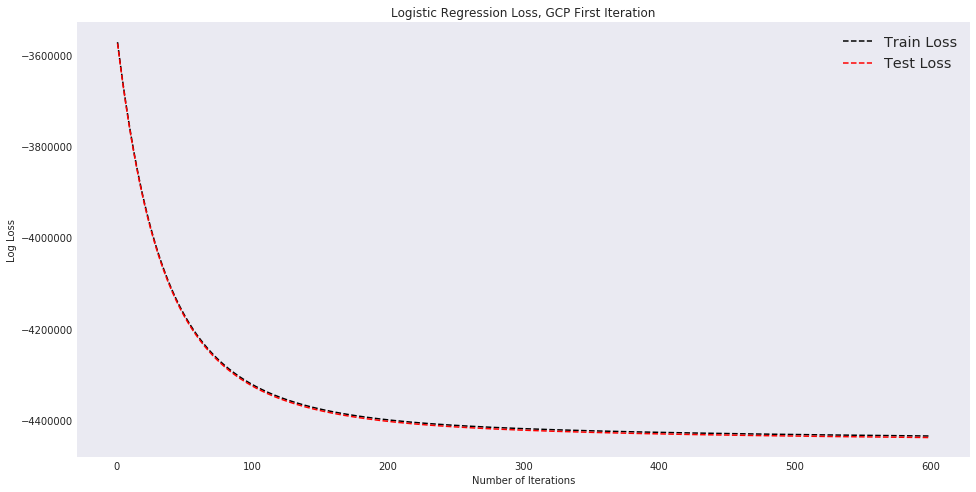

In [43]:
plotErrorCurves(trainloss2, testLoss = testloss2,  title = 'Logistic Regression Loss, GCP First Iteration' )

In [6]:
trainloss3 = [-3548636.4270913936, -3573006.58547297, -3596641.6951384116, -3619557.2804933744, -3641768.9965235554, -3663292.726975275, -3684144.748348546, -3704341.7573945653, -3723900.8172837268, -3742839.2699413383, -3761174.6389778447, -3778924.5345418253, -3796106.5651110657, -3812738.2582522235, -3828836.9909386993, -3844419.929299712, -3859503.977315607, -3874105.7337987525, -3888241.4569257647, -3901927.035569097, -3915177.9666930935, -3928009.338113859, -3940435.8159688297, -3952471.6362935537, -3964130.600155008, -3975426.071844893, -3986370.979685251, -3996977.8190486343, -4007258.657237495, -4017225.1399107613, -4026888.4987811185, -4036259.560342335, -4045348.755415505, -4054166.129331071, -4062721.3525884366, -4071023.7318561464, -4079082.2211957793, -4086905.4334094264, -4094501.6514258506, -4101878.839653659, -4109044.6552417963, -4116006.4591971794, -4122771.327318949, -4129346.0609156927, -4135737.1972794724, -4141951.0198956085, -4147993.5683724927, -4153870.6480796877, -4159587.83948672, -4165150.507197221, -4170563.8086766563, -4175832.702673275, -4180961.957334203, -4185956.158020233, -4190819.7148234784, -4195556.869793936, -4200171.703881118, -4204668.143598095, -4209049.967415467, -4213320.811892684, -4217484.177556097, -4221543.434531029, -4225501.827936544, -4229362.48305204, -4233128.4102632245, -4236802.509796404, -4240387.576249183, -4243886.302925382, -4247301.285982597, -4250635.028399775, -4253889.943772178, -4257068.35994139, -4260172.522467185, -4263204.597947925, -4266166.677196554, -4269060.778277924, -4271888.849413985, -4274652.771762512, -4277354.362075032, -4279995.375239334, -4282577.50671184, -4285102.394844637, -4287571.623112066, -4289986.722241298, -4292349.172251388, -4294660.404404673, -4296921.8030749, -4299134.707535623, -4301300.413672226, -4303420.175621831, -4305495.207343236, -4307526.684121386, -4309515.744007917, -4311463.489201948, -4313370.987372912, -4315239.272928554, -4317069.34823036, -4318862.184758784, -4320618.724230594, -4322339.879670429, -4324026.53643859, -4325679.553217317, -4327299.76295662, -4328887.973782595, -4330444.969868745, -4331971.512272771, -4333468.339739963, -4334936.169474627, -4336375.697881272, -4337787.601276401, -4339172.536572658, -4340531.14193617, -4341864.037418384, -4343171.82556362, -4344455.0919930115, -4345714.405966431, -4346950.320922615, -4348163.3749990575, -4349354.09153219, -4350522.979538611, -4351670.534178553, -4352797.237201804, -4353903.557377356, -4354989.950906908, -4356056.861823388, -4357104.72237488, -4358133.953394331, -4359144.964656126, -4360138.155219779, -4361113.91376111, -4362072.618891667, -4363014.639466941, -4363940.334883398, -4364850.055365278, -4365744.142241242, -4366622.928211424, -4367486.737605168, -4368335.886629903, -4369170.683611525, -4369991.429226421, -4370798.416725831, -4371591.93215258, -4372372.254550419, -4373139.656166586, -4373894.402647574, -4374636.753228618, -4375366.960916909, -4376085.27266894, -4376791.92956243, -4377487.166962594, -4378171.21468367, -4378844.297145257, -4379506.633524187, -4380158.4379022075, -4380799.919409441, -4381431.282364112, -4382052.726408733, -4382664.446643152, -4383266.633754631, -4383859.474145261, -4384443.150057124, -4385017.83969529, -4385583.717348918, -4386140.953510599, -4386689.714993729, -4387230.165048128, -4387762.463472441, -4388286.766723151, -4388803.228018074, -4389311.997431949, -4389813.221980858, -4390307.045691293, -4390793.609648991, -4391273.0520222755, -4391745.508056455, -4392211.11003775, -4392669.987231074, -4393122.265802774, -4393568.068745896, -4394007.515830645, -4394440.7236003475, -4394867.805425726, -4395288.871617984, -4395704.029589329, -4396113.384043007, -4396517.037173181, -4396915.088858719, -4397307.63683952, -4397694.7768685855, -4398076.602837456, -4398453.206875344, -4398824.6794246705, -4399191.109297231, -4399552.583715506, -4399909.188342959, -4400261.007307252, -4400608.123219525, -4400950.617190781, -4401288.5688479245, -4401622.056349627, -4401951.156402962, -4402275.944280754, -4402596.493840158, -4402912.87754217, -4403225.166471965, -4403533.430360358, -4403837.737605742, -4404138.155296762, -4404434.749235334, -4404727.583959928, -4405016.72276937, -4405302.22774627, -4405584.15978086, -4405862.578594577, -4406137.542763464, -4406409.109741482, -4406677.335883436, -4406942.276467813, -4407203.985719028, -4407462.516829472, -4407717.921981161, -4407970.252366919, -4408219.558211334, -4408465.888790996, -4408709.292454555, -4408949.81664231, -4409187.507905222, -4409422.411923765, -4409654.573525984, -4409884.036705571, -4410110.844639095, -4410335.039703084, -4410556.663490729, -4410775.756827937, -4410992.359789226, -4411206.511713229, -4411418.251217672, -4411627.616214084, -4411834.643922246, -4412039.370884043, -4412241.832977368, -4412442.065429173, -4412640.102828812, -4412835.97914058, -4413029.7277161805, -4413221.381306936, -4413410.972075612, -4413598.531608074, -4413784.090924583, -4413967.680490889, -4414149.330229249, -4414329.069528742, -4414506.927256063, -4414682.931765289, -4414857.110908261, -4415029.492044019, -4415200.102048475, -4415368.967323925, -4415536.113808008, -4415701.566982839, -4415865.351883734, -4416027.493108029, -4416188.014823297, -4416346.940775894, -4416504.294299014, -4416660.098320596, -4416814.375371244, -4416967.147591834, -4417118.436741174, -4417268.264203139, -4417416.650994133, -4417563.617769998, -4417709.184833112, -4417853.372138951, -4417996.199303086, -4418137.68560736, -4418277.85000656, -4418416.711134502, -4418554.287310278, -4418690.596544239, -4418825.656543753, -4418959.484719178, -4419092.098189345, -4419223.513787162, -4419353.748064958, -4419482.817299747, -4419610.737498549, -4419737.524403323, -4419863.193495965, -4419987.7600031905, -4420111.23890121, -4420233.64492046, -4420354.992550109, -4420475.296042574, -4420594.569417626, -4420712.826467105, -4420830.08075862, -4420946.34564001, -4421061.634243046, -4421175.959487561, -4421289.334085144, -4421401.770542998, -4421513.2811674895, -4421623.878067818, -4421733.573159579, -4421842.378168128, -4421950.304631953, -4422057.36390613, -4422163.567165299, -4422268.925407148, -4422373.449455242, -4422477.149962296, -4422580.037413015, -4422682.1221271455, -4422783.414262116, -4422883.9238162385, -4422983.660631095, -4423082.63439442, -4423180.854642762, -4423278.330764027, -4423375.072000127, -4423471.087449318, -4423566.38606886, -4423660.976677263, -4423754.867956756, -4423848.068455589, -4423940.586590273, -4424032.4306478705, -4424123.608788172, -4424214.129045809, -4424303.999332418, -4424393.227438753, -4424481.821036662, -4424569.787681111, -4424657.134812158, -4424743.869756837, -4424829.99973117, -4424915.531841998, -4425000.473088554, -4425084.83036475, -4425168.610460521, -4425251.820063742, -4425334.465761912, -4425416.554043783, -4425498.091301121, -4425579.083830115, -4425659.537833226, -4425739.459420501, -4425818.8546112245, -4425897.729335476, -4425976.089435456, -4426053.940667109, -4426131.288701378, -4426208.139125781, -4426284.497445668, -4426360.369085599, -4426435.759390695, -4426510.673627954, -4426585.116987478, -4426659.09458382, -4426732.611457163, -4426805.672574531, -4426878.282831075, -4426950.4470511535, -4427022.16998948, -4427093.456332385, -4427164.310698803, -4427234.737641452, -4427304.741647805, -4427374.32714133, -4427443.498482332, -4427512.2599691795, -4427580.615839123, -4427648.570269346, -4427716.127378039, -4427783.291225276, -4427850.065813811, -4427916.455090331, -4427982.462946026, -4428048.093217729, -4428113.349688635, -4428178.2360892, -4428242.756098125, -4428306.913342914, -4428370.711400931, -4428434.153800137, -4428497.244019814, -4428559.985491437, -4428622.381599373, -4428684.435681627, -4428746.151030648, -4428807.530894007, -4428868.578475034, -4428929.2969337255, -4428989.6893871855, -4429049.758910507, -4429109.508537335, -4429168.9412604915, -4429228.060032714, -4429286.86776722, -4429345.367338345, -4429403.5615822235, -4429461.4532971755, -4429519.045244605, -4429576.340149295, -4429633.340700208, -4429690.049550863, -4429746.469319999, -4429802.60259209, -4429858.451917868, -4429914.019814847, -4429969.3087678505, -4430024.3212295165, -4430079.059620797, -4430133.526331418, -4430187.723720393, -4430241.654116537, -4430295.319818857, -4430348.72309698, -4430401.866191745, -4430454.751315561, -4430507.380652759, -4430559.756360175, -4430611.88056753, -4430663.755377744, -4430715.382867461, -4430766.765087402, -4430817.9040627405, -4430868.801793513, -4430919.460254998, -4430969.881398171, -4431020.067149813, -4431070.019413228, -4431119.74006834, -4431169.230972138, -4431218.493958996, -4431267.530841057, -4431316.343408503, -4431364.933429934, -4431413.302652706, -4431461.452803129, -4431509.385586917, -4431557.102689449, -4431604.6057760455, -4431651.896492283, -4431698.976464276, -4431745.847299031, -4431792.510584598, -4431838.967890473, -4431885.220767809, -4431931.270749693, -4431977.119351436, -4432022.768070761, -4432068.218388172, -4432113.471767145, -4432158.52965432, -4432203.393479867, -4432248.064657577, -4432292.544585328, -4432336.834644982, -4432380.936202916, -4432424.85061018, -4432468.57920259, -4432512.123301001, -4432555.484211624, -4432598.663226089, -4432641.661621812, -4432684.480662061, -4432727.121596178, -4432769.5856598485, -4432811.874075246, -4432853.988051225, -4432895.928783514, -4432937.69745487, -4432979.295235332, -4433020.723282338, -4433061.982741003, -4433103.074744046, -4433144.000412278, -4433184.760854592, -4433225.357168066, -4433265.790438302, -4433306.061739521, -4433346.172134638, -4433386.122675521, -4433425.91440308, -4433465.548347437, -4433505.025528102, -4433544.346954094, -4433583.513624084, -4433622.526526495, -4433661.38663975, -4433700.094932304, -4433738.652362838, -4433777.059880344, -4433815.318424295, -4433853.428924774, -4433891.3923026, -4433929.209469396, -4433966.881327786, -4434004.408771475, -4434041.7926854, -4434079.033945829, -4434116.13342041, -4434153.091968446, -4434189.910440849, -4434226.589680284, -4434263.13052137, -4434299.533790678, -4434335.800306874, -4434371.930880895, -4434407.926315845, -4434443.787407391, -4434479.514943551, -4434515.109705069, -4434550.572465342, -4434585.903990535, -4434621.10503972, -4434656.176364891, -4434691.1187112, -4434725.9328168975, -4434760.6194135, -4434795.179225764, -4434829.612971984, -4434863.921363876, -4434898.105106747, -4434932.164899568, -4434966.101435061, -4434999.915399724, -4435033.6074739555, -4435067.178332195, -4435100.6286428105, -4435133.959068414, -4435167.170265702, -4435200.262885744, -4435233.237573838, -4435266.094969724, -4435298.835707647, -4435331.4604163645, -4435363.969719262, -4435396.364234339, -4435428.644574428, -4435460.811347075, -4435492.865154735, -4435524.806594823, -4435556.636259655, -4435588.354736653, -4435619.96260837, -4435651.460452424, -4435682.848841773, -4435714.12834458, -4435745.299524381, -4435776.362940062, -4435807.319145981, -4435838.1686920235, -4435868.912123551, -4435899.549981612, -4435930.082802835, -4435960.511119602, -4435990.83546002, -4436021.0563480435, -4436051.17430342, -4436081.189841823, -4436111.10347491, -4436140.915710234, -4436170.627051503, -4436200.237998429, -4436229.749046862, -4436259.160688852, -4436288.473412667, -4436317.687702746, -4436346.804039957, -4436375.822901439, -4436404.744760681, -4436433.570087694, -4436462.299348784, -4436490.933006972, -4436519.471521631, -4436547.915348794, -4436576.264941142, -4436604.520747895, -4436632.683215079, -4436660.75278539, -4436688.729898271, -4436716.614989942, -4436744.40849354, -4436772.110838956, -4436799.7224531025, -4436827.243759634, -4436854.6751793735, -4436882.017129995, -4436909.270026269, -4436936.434280008, -4436963.51030004, -4436990.498492426, -4437017.399260317, -4437044.213004072, -4437070.940121197, -4437097.581006476, -4437124.136051929]
testloss3 = [-3550592.98629282, -3574948.706722877, -3598569.771248202, -3621471.5806724196, -3643669.798267769, -3665180.3381848917, -3686019.504129689, -3706204.011840764, -3725750.9352098354, -3744677.619925874, -3763001.5879892595, -3780740.4440293335, -3797911.788306276, -3814533.138409574, -3830621.860273069, -3846195.1084259367, -3861269.775040315, -3875862.4471535017, -3889989.3713615667, -3903666.425255662, -3916909.094882499, -3929732.457541461, -3942151.1692725318, -3954179.45643825, -3965831.1108542914, -3977119.487973677, -3988057.507680756, -3998657.6572965197, -4008931.9964429885, -4018892.1634534714, -4028549.38305407, -4037914.47507495, -4046997.8639810923, -4055809.589039714, -4064359.3149649347, -4072656.3429047563, -4080709.6216514227, -4088527.7589765084, -4096119.033005134, -4103491.4035578654, -4110652.523400396, -4117609.7493509455, -4124370.1532048597, -4130940.53244268, -4137327.4206954762, -4143537.0979462108, -4149575.6004518857, -4155448.7303742175, -4161162.0651112758, -4166720.9663251024, -4172130.588662964, -4177395.8881724635, -4182521.630411907, -4187512.3982596374, -4192372.5994266565, -4197106.473678418, -4201718.09977171, -4206211.4021146, -4210590.15715583, -4214857.999512921, -4219018.427845862, -4223074.810486032, -4227030.390827588, -4230888.292490766, -4234651.5242650695, -4238322.984840525, -4241905.4673356805, -4245401.663630182, -4248814.168509691, -4252145.483631193, -4255398.021315807, -4258574.108176708, -4261675.988588881, -4264705.828007914, -4267665.716143975, -4270557.669997481, -4273383.63676273, -4276145.496605062, -4278845.065317264, -4281484.096860841, -4284064.285796913, -4286587.269612044, -4289054.630943628, -4291467.899709364, -4293828.555145061, -4296138.027755314, -4298397.701180321, -4300608.913983435, -4302772.9613624895, -4304891.096788422, -4306964.5335749835, -4308994.44638173, -4310981.972654511, -4312928.214005067, -4314834.237533422, -4316701.077095072, -4318529.734515982, -4320321.180757035, -4322076.357030957, -4323796.175873246, -4325481.522169496, -4327133.254141103, -4328752.204290691, -4330339.18030999, -4331894.96595059, -4333420.321860497, -4334915.9863869455, -4336382.676347592, -4337821.087771184, -4339231.896609112, -4340615.759419125, -4341973.3140223315, -4343305.180134847, -4344611.959974935, -4345894.238846575, -4347152.585701271, -4348387.553677703, -4349599.680621527, -4350789.489585112, -4351957.489308671, -4353104.174683353, -4354230.027196978, -4355335.515363408, -4356421.095135849, -4357487.210305152, -4358534.292883345, -4359562.763473358, -4360573.0316252485, -4361565.496179727, -4362540.545598905, -4363498.558285927, -4364439.902892462, -4365364.93861598, -4366274.015486117, -4367167.474641089, -4368045.648594627, -4368908.861493462, -4369757.429366042, -4370591.660362501, -4371411.854986794, -4372218.3063205825, -4373011.300239681, -4373791.115623286, -4374558.024556203, -4375312.292524162, -4376054.178603065, -4376783.935641603, -4377501.810438316, -4378208.043912539, -4378902.871270322, -4379586.522164728, -4380259.2208512155, -4380921.186338149, -4381572.632532933, -4382213.768383349, -4382844.79801508, -4383465.920864909, -4384077.3318105135, -4384679.221296402, -4385271.775456992, -4385855.176235998, -4386429.601503797, -4386995.225171744, -4387552.217304603, -4388100.744230836, -4388640.968651609, -4389173.049748119, -4389697.1432877295, -4390213.401729107, -4390721.974325483, -4391223.007226177, -4391716.643574465, -4392203.023600277, -4392682.284704635, -4393154.561532132, -4393619.986025955, -4394078.6874610465, -4394530.792449463, -4394976.424916863, -4395415.706052192, -4395848.754240717, -4396275.685000028, -4396696.610942968, -4397111.641793961, -4397520.884473955, -4397924.443250953, -4398322.419924497, -4398714.913982842, -4399102.0226477645, -4399483.840727912, -4399860.460269946, -4400231.970145399, -4400598.455880573, -4400960.0000458965, -4401316.683234563, -4401668.585236073, -4402015.785848122, -4402358.365040234, -4402696.402597783, -4403029.977579109, -4403359.167850026, -4403684.049797771, -4404004.698208319, -4404321.186250238, -4404633.585512898, -4404941.966065255, -4405246.396516804, -4405546.94407381, -4405843.674588504, -4406136.65260176, -4406425.941380277, -4406711.60294983, -4406993.698125514, -4407272.2865397, -4407547.426668625, -4407819.175857795, -4408087.5903465785, -4408352.725291962, -4408614.634792171, -4408873.3719094265, -4409128.9886924755, -4409381.536198545, -4409631.064515055, -4409877.622780632, -4410121.259206063, -4410362.02109432, -4410599.954860425, -4410835.106050895, -4411067.519362439, -4411297.238660437, -4411524.306996758, -4411748.76662725, -4411970.659028624, -4412190.024914998, -4412406.904253916, -4412621.3362819385, -4412833.359519922, -4413043.011787572, -4413250.330217964, -4413455.351271527, -4413658.110749511, -4413858.64380728, -4414056.984967199, -4414253.16813122, -4414447.226593113, -4414639.193050324, -4414829.099615654, -4415016.977828659, -4415202.85866661, -4415386.772555488, -4415568.749380432, -4415748.818496174, -4415927.008737042, -4416103.348426959, -4416277.865389109, -4416450.586955476, -4416621.539975985, -4416790.750827831, -4416958.24542425, -4417124.049223361, -4417288.1872367505, -4417450.68403792, -4417611.563770526, -4417770.85015656, -4417928.566504364, -4418084.735716315, -4418239.380296694, -4418392.522359174, -4418544.183634298, -4418694.38547659, -4418843.148872038, -4418990.4944448, -4419136.44246434, -4419281.012852154, -4419424.225188336, -4419566.098718205, -4419706.652358738, -4419845.904704836, -4419983.87403547, -4420120.578319707, -4420256.035222775, -4420390.2621118575, -4420523.276061662, -4420655.093860195, -4420785.732014103, -4420915.206754152, -4421043.534040484, -4421170.729567638, -4421296.808769736, -4421421.786825355, -4421545.67866245, -4421668.498962895, -4421790.262167314, -4421910.982479513, -4422030.673870913, -4422149.350084959, -4422267.024641204, -4422383.710839613, -4422499.421764618, -4422614.170288998, -4422727.969077807, -4422840.830592159, -4422952.76709301, -4423063.790644794, -4423173.913118772, -4423283.14619684, -4423391.5013747495, -4423498.98996541, -4423605.623102314, -4423711.411742557, -4423816.366670105, -4423920.498498729, -4424023.817675145, -4424126.334481839, -4424228.059040015, -4424329.001312327, -4424429.171105811, -4424528.578074318, -4424627.231721504, -4424725.141403117, -4424822.31632976, -4424918.765569201, -4425014.498049085, -4425109.522558998, -4425203.84775317, -4425297.482152577, -4425390.434147152, -4425482.711998188, -4425574.323840458, -4425665.277684266, -4425755.581417675, -4425845.242808491, -4425934.269506331, -4426022.669044547, -4426110.4488422135, -4426197.616206135, -4426284.178332521, -4426370.142309081, -4426455.5151165845, -4426540.303630838, -4426624.514624375, -4426708.154768123, -4426791.230633176, -4426873.748692339, -4426955.715321917, -4427037.136803215, -4427118.01932407, -4427198.368980473, -4427278.191778065, -4427357.493633649, -4427436.280376598, -4427514.557750372, -4427592.331413869, -4427669.606942792, -4427746.389831182, -4427822.6854925025, -4427898.499261191, -4427973.836393826, -4428048.702070465, -4428123.101395841, -4428197.0394006595, -4428270.5210426785, -4428343.551208109, -4428416.134712652, -4428488.27630257, -4428559.980655986, -4428631.252383849, -4428702.096031185, -4428772.516078032, -4428842.516940447, -4428912.102971761, -4428981.278463403, -4429050.047645947, -4429118.414690144, -4429186.383707862, -4429253.958752989, -4429321.1438224, -4429387.942856953, -4429454.359742274, -4429520.398309672, -4429586.062337089, -4429651.355549817, -4429716.281621472, -4429780.844174745, -4429845.046782299, -4429908.892967435, -4429972.386204986, -4430035.529922085, -4430098.327498856, -4430160.78226924, -4430222.897521594, -4430284.6764997095, -4430346.1224031495, -4430407.238388191, -4430468.027568396, -4430528.493015414, -4430588.637759536, -4430648.464790282, -4430707.977057276, -4430767.177470598, -4430826.068901652, -4430884.654183608, -4430942.936112048, -4431000.917445541, -4431058.600906298, -4431115.989180668, -4431173.0849197, -4431229.89073969, -4431286.409222751, -4431342.642917372, -4431398.594338851, -4431454.265969881, -4431509.660260982, -4431564.779631163, -4431619.626468196, -4431674.203129234, -4431728.511941264, -4431782.555201522, -4431836.335177923, -4431889.854109778, -4431943.11420782, -4431996.117654928, -4432048.86660649, -4432101.3631907385, -4432153.609509316, -4432205.607637519, -4432257.359624811, -4432308.867495243, -4432360.133247616, -4432411.158856168, -4432461.946270773, -4432512.497417258, -4432562.8141979445, -4432612.898491844, -4432662.752155083, -4432712.377021224, -4432761.774901625, -4432810.947585759, -4432859.896841507, -4432908.624415561, -4432957.132033673, -4433005.421400946, -4433053.494202224, -4433101.352102399, -4433148.996746533, -4433196.429760387, -4433243.652750504, -4433290.667304718, -4433337.474992128, -4433384.077363679, -4433430.4759522015, -4433476.67227281, -4433522.667823096, -4433568.464083429, -4433614.062517187, -4433659.464570957, -4433704.671674869, -4433749.6852428, -4433794.5066725155, -4433839.137346094, -4433883.578630003, -4433927.83187537, -4433971.898418104, -4434015.779579421, -4434059.476665617, -4434102.990968703, -4434146.323766274, -4434189.476321913, -4434232.449885359, -4434275.245692612, -4434317.864966207, -4434360.308915472, -4434402.5787365595, -4434444.675612747, -4434486.600714479, -4434528.355199809, -4434569.94021428, -4434611.356891301, -4434652.606352233, -4434693.689706543, -4434734.608052024, -4434775.362474892, -4434815.954050103, -4434856.383841222, -4434896.652900905, -4434936.762270774, -4434976.712981785, -4435016.506054209, -4435056.142497878, -4435095.6233122945, -4435134.949486792, -4435174.122000649, -4435213.141823199, -4435252.009914049, -4435290.727223157, -4435329.294690937, -4435367.713248497, -4435405.983817561, -4435444.107310824, -4435482.084631928, -4435519.916675671, -4435557.604327971, -4435595.1484662285, -4435632.549959205, -4435669.809667286, -4435706.928442517, -4435743.90712876, -4435780.746561725, -4435817.447569252, -4435854.010971172, -4435890.437579512, -4435926.72819882, -4435962.883625795, -4435998.904649876, -4436034.792052989, -4436070.54660979, -4436106.169087764, -4436141.660247313, -4436177.020841729, -4436212.251617551, -4436247.353314262, -4436282.326664821, -4436317.172395349, -4436351.891225477, -4436386.48386839, -4436420.951030728, -4436455.293412915, -4436489.511709075, -4436523.606607143, -4436557.578789035, -4436591.428930558, -4436625.157701628, -4436658.765766283, -4436692.253782719, -4436725.62240349, -4436758.872275397, -4436792.004039741, -4436825.01833226, -4436857.915783262, -4436890.69701765, -4436923.362654993, -4436955.913309671, -4436988.349590809, -4437020.672102452, -4437052.881443527, -4437084.9782080185, -4437116.962984907, -4437148.836358326, -4437180.598907569, -4437212.251207157, -4437243.7938269, -4437275.2273319615, -4437306.552282844, -4437337.769235593, -4437368.8787416965, -4437399.881348198, -4437430.777597786, -4437461.568028803, -4437492.253175196, -4437522.833566871, -4437553.30972939, -4437583.682184188, -4437613.951448649, -4437644.118036085, -4437674.1824558135, -4437704.14521319, -4437734.006809658, -4437763.76774278, -4437793.428506334, -4437822.989590231, -4437852.451480768, -4437881.8146604365, -4437911.079608081, -4437940.246799001, -4437969.31670487, -4437998.289793843, -4438027.166530561, -4438055.947376204, -4438084.632788528, -4438113.2232219875, -4438141.719127525, -4438170.120952927, -4438198.429142611, -4438226.644137868, -4438254.766376609, -4438282.796293753, -4438310.734320951, -4438338.580886827, -4438366.336416882, -4438394.001333664, -4438421.576056636, -4438449.0610022815, -4438476.45658426, -4438503.763213115, -4438530.981296721, -4438558.111240008, -4438585.153445038, -4438612.108311151, -4438638.976234882, -4438665.757610092]

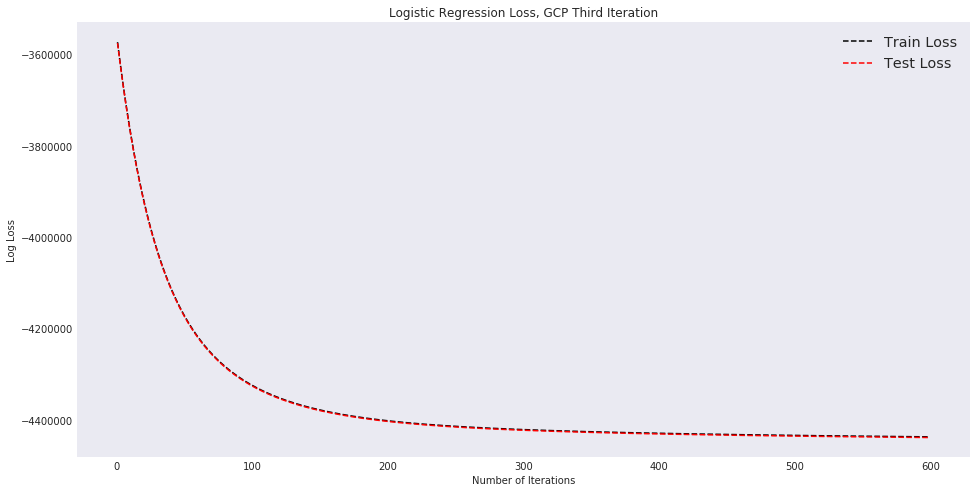

In [8]:
plotErrorCurves(trainloss3, testLoss = testloss3,  title = 'Logistic Regression Loss, GCP Third Iteration' )

Due to time constraints, we are unable to show the final result from this run at the time of submission, but we will submit the corresponding log file. 

# __Section 5__ - Course Concepts


### Scalability

This dataset is the largest that we have had to work with, which meant that if we wanted to run our algorithm on the full training dataset to build the model and then predict on the test dataset, our functions and Spark jobs had to be scalable and run on tens of millions of rows potentially. Given the volume of data, the algorithm must also run effectively and efficiently in Google Cloud Platform. The best way to design the algorithm this way is to use a toy dataset to test the concept and perform further testing on a larger set before finally running on the full data. Unfortunately, a part of our feature selection and preprocessing was not able to handle larger volumes of data once we moved to GCP. In our troubleshooting process with this aspect of the code, we analyzed potential pain points with the code, such as sending too much information to the master with a collect action for example. This showed us how important these considerations are when we have to deal with big, high dimensional data in a production setting.

### Functional Programming & Higher Order Functions

In order to utilize Spark, we employed several functional programming principles, namely the usage of higher order functions through map tasks. From our EDA to our homegrown algorithm, we wrote numerous user defined functions to perform a variety of operations such as parsing the lines or generating new key-value pairs. Our work on this project required multiple jobs to perform operations on the data, so we emphasized the principle of statelessness in order to perserve the integrity of the original data. As an example, this meant performing transformations on an RDD to return another RDD. 

### Pre-processing for Random Forest vs. Logistic Regression

We attempted to employ two different machine learning models at different stage of our model building. We recognized the benefits of using Random Forest on this particular dataset given that there were concerns about missing values and the dimensionality of the categorical variables. In order to improve the training time with Random Forest, we utilized Breiman's algorithm to rank the categories and bin them accordingly. On the other hand, with Logistic Regression, we recognized the importance of imputing the missing values, scaling the features, and one-hot encoding the categorical features in order to learn the coefficients of the model.

### Feature Selection & Model Complexity

Given the mix of numerical and categorical features in the dataset, feature selection played an important role in reducing model complexity as well as reducing training and prediction time. After EDA, we removed features that contained a large portion of missing values and features that had a majority of unique categories. Then, we sought to perform feature selection with a Random Forest model to obtain a ranking of the features after binning the categorical features. We also performed L1 regularization to see if any of the features were reduced to a zero coefficient. These considerations helped us develop a parsimonious model.

## Sources

Albon, C. (2017, December 20). Feature Selection Using Random Forest. Retrieved from https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

Chapelle, O., Manavoglu, E., & Rosales, R. (2014). Simple and Scalable Response Prediction for Display Advertising. ACM Transactions on Intelligent Systems and Technology, 5(4), 1-34. doi:10.1145/2532128

He, X., Bowers, S., Candela, J. Q., Pan, J., Jin, O., Xu, T., . . . Herbrich, R. (2014). Practical Lessons from Predicting Clicks on Ads at Facebook. Proceedings of 20th ACM SIGKDD Conference on Knowledge Discovery and Data Mining - ADKDD14. doi:10.1145/2648584.2648589

Lin, T. (n.d.). Feature Selection Using Feature Importance Score - Creating a PySpark Estimator. Retrieved from https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/